<h1 style="font-family: Arial; font-weight: 900; color: magenta; text-align: center;">DATA PREPROCESSING</h1><br>

<br/><div style="font-family: Arial; color: darkblue; font-size: 14px; font-weight: 600"><a id="toc"></a>
In this part 4:
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[1. Dealing with missing data](#1)</p>
        <p style="margin: 0 0 0 4rem">[1a. Identifying missing values](#1a)</p>
        <p style="margin: 0 0 0 4rem">[1b. Eliminating data](#1b)</p>
        <p style="margin: 0 0 0 4rem">[1c. Imputing missing values](#1c)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[2. Handling categorical data](#2)</p>
        <p style="margin: 0 0 0 4rem">[2a. What is categorical data ?](#2a)</p>
        <p style="margin: 0 0 0 4rem">[2b. Mapping ordinal features](#2b)</p>
        <p style="margin: 0 0 0 4rem">[2c. Encoding class labels](#2c)</p>
        <p style="margin: 0 0 0 4rem">[2d. Performing one-hot encoding on nominal features](#2d)</p><br>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[3. Preparation of a dataset](#3)</p>
        <p style="margin: 0 0 0 4rem">[3a. Partitioning a dataset between a training and a test dataset](#3a)</p>
        <p style="margin: 0 0 0 4rem">[3b. Bringing features onto the same scale](#3b)</p><br>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[4. Selecting meaningful features](#4)</p>
        <p style="margin: 0 0 0 4rem">[4a. $L^1$ and $L^2$-regularizations](#4a)</p>
        <p style="margin: 0 0 0 4rem">[4b. $L^1$ and $L^2$-regularizers in scikit-learn](#4b)</p>
        <p style="margin: 0 0 0 4rem">[4c. Sequential feature selection algorithms](#4c)</p>
        <p style="margin: 0 0 0 4rem">[4d. Assessing feature importance with random forests](#4d)</p></div>

In [1]:
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The datasets we will use
df_wine = pd.read_csv('wine.data', header=None)

# Beautify code results using colors
from colorama import Fore, Back, Style
# Define some strings for cleaner code
BB = Fore.BLUE + Style.BRIGHT
MB = Fore.MAGENTA + Style.BRIGHT

# Beautify DataFrames using colors
def beautify(df):
    # df.style creates a Styler object from the DataFrame df, which allows styling to be applied to the
    # dataframe's representation; then 'set_table_styles' applies css styling (eg 'text-align: center')
    # to the table header cells (<th>) and data cells (<td>) of the dataframe
    styled_df = df.style.set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('color', 'blue')]}, 
        {'selector': 'td', 'props': [('text-align', 'center'), ('color', 'magenta'), ('font-weight', 'bold')]}])    
    # The Styler object resets the precision of floats to 6 decimal places, whatever their original format; only
    # the display is affected, though, not the original data; here, the floats are float64 numbers and correspond
    # to prices or percentages, so I reformat their display to 2 decimal places
    return styled_df.format({col: '{:.2f}' for col in df.select_dtypes(include=['float64'])})

# Beautify figures by rendering them in SVG quality instead of JPG
# (don't use this if you prefer lightweight notebooks)
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
# we'll use the "cyberpunk" color map
cmap = plt.get_cmap("cool")

<a id="1"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>1. DEALING WITH MISSING DATA</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1a. Identifying missing values</font><a id="1a"></a></p>$\quad$
        It is not uncommon in real-world applications for our training examples to be missing one or more values for various reasons. There could have been an error in the data collection process, certain measurements may not be applicable, or particular fields could have been simply left blank in a survey, for example. We typically see missing values as blank spaces in our data table or as placeholder strings such as NaN, or NULL (a commonly used indicator of unknown values in relational databases). Unfortunately, most computational tools are unable to handle such missing values or will produce unpredictable results if we simply ignore them. Therefore, it is crucial that we
take care of those missing values before we proceed with further analyses.<br>
    Before we discuss several techniques for dealing with missing values, let’s create a simple example DataFrame from a comma-separated values (CSV) file to get a better grasp of the problem. We can see that the two missing values in our file have been replaced by 'NaN' in our dataframe 'df'. In a big dataset it may be useful to check if some feature do miss some data, and how many; we can do this by code : <font color='#5555ff'>print(df.isnull().sum())</font>

In [2]:
# The '''<string>''' allows us to write a string over several lines; we could also write
# csv_data = "A,B,C,D\n1.0,2.0,3.0,4.0\n5.0,6.0,,8.0\n10.0,11.0,12.0";
csv_data = '''
A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# 'StringIO' transforms a string as if it were a '.csv' file on the disk
df = pd.read_csv(StringIO(csv_data))
print(BB + "df =\n" + MB, df)

# df.isnull() returns an array of the same shape as 'df', each entry being 'True' iff
# the corresponding entry in 'df' is null, and 'False' otherwise
# by default, the 'sum()' is applied to the columns, and is equivalent to 'sum(axis=0)'
df2 = df.isnull().sum()
print(BB + "\ndf.isnull().sum() =\n" + Fore.MAGENTA, df.isnull().sum())

df =
       A     B     C    D
0   1.0   2.0   3.0  4.0
1   5.0   6.0   NaN  8.0
2  10.0  11.0  12.0  NaN

df.isnull().sum() =
 A    0
B    0
C    1
D    1
dtype: int64


<br><br><div style="font-family: Arial; font-size:14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1b. Eliminating data</font><a id="1b"></a></p>$\quad$
        One of the easiest ways to deal with missing data is simply to remove the corresponding features (columns) or training examples (rows) from the dataset entirely; this is done via the dropna method, which can also remove columns or rows  depending on some arguments :

In [3]:
# 'df.dropna(axis=0)' removes rows where at least one element is missing (ie is 'NaN' or 'None')
print(BB + "df.dropna(axis=0) =\n" + MB, df.dropna(axis=0))

# while 'df.dropna(axis=1)' removes columns where at least one element is missing
print(BB + "\ndf.dropna(axis=1) =\n" + MB, df.dropna(axis=1))

# 'df.dropna(how='all')' removes rows full of missing elements
print(BB + "\ndf.dropna(how='all') =\n" + MB, df.dropna(how='all'))

# 'df.dropna(thresh=4)' removes rows that have fewer than 4 real values
print(BB + "\ndf.dropna(thresh=4) =\n" + MB, df.dropna(thresh=4))

# 'df.dropna(subset=[<column names>])' only removes rows where a missing value appear in specific
# columns (here: 'C')
print(BB + "\ndf.dropna(subset=['C']) =\n" + MB, df.dropna(subset=['C']))

df.dropna(axis=0) =
      A    B    C    D
0  1.0  2.0  3.0  4.0

df.dropna(axis=1) =
       A     B
0   1.0   2.0
1   5.0   6.0
2  10.0  11.0

df.dropna(how='all') =
       A     B     C    D
0   1.0   2.0   3.0  4.0
1   5.0   6.0   NaN  8.0
2  10.0  11.0  12.0  NaN

df.dropna(thresh=4) =
      A    B    C    D
0  1.0  2.0  3.0  4.0

df.dropna(subset=['C']) =
       A     B     C    D
0   1.0   2.0   3.0  4.0
2  10.0  11.0  12.0  NaN


<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1c. Imputing missing values</font><a id="1c"></a></p>$\quad$
        Although the removal of missing data seems to be a convenient approach, it also comes with certain disadvantages; for example, we may end up removing too many samples, which will make a reliable analysis impossible. Or, if we remove too many feature columns, we will run the risk of losing valuable information that our classifier needs to discriminate between classes. In this case, we can use different interpolation techniques to estimate the missing values from the other training examples in our dataset.<br>
    One of the most common interpolation techniques is mean imputation, where we simply replace the missing value with the mean value of the entire feature column. A convenient way to achieve this is by using the '$\,$<font color='#cc33ff'>SimpleImputer</font>$\,$' class from <font color='#cc33ff'>scikit-learn</font>, as shown in the following code. The default value for its 'strategy' parameter is '<font color='#cc33ff'>mean</font>'; another useful possibility is '<font color='#cc33ff'>most_frequent</font>' which is great with strings or for classes, and returns the most frequent value along each column, and if there is a tie then only the smallest is returned (whatever it means according to <font color='#cc33ff'>scikit-learn</font>).

In [4]:
from sklearn.impute import SimpleImputer
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
print(BB + "imputed_data =\n" + MB, imputed_data)

imputed_data =
 [[ 1.   2.   3.   4. ]
 [ 5.   6.   7.5  8. ]
 [10.  11.  12.   6. ]]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        A more convenient way to achieve the same result is by using pandas' $\,$<font color='#cc33ff'>fillna</font>$\,$ method and providing an imputation method as an argument. For example :

In [5]:
print(BB + "imputed_data =\n" + MB, df.fillna(df.mean()))

imputed_data =
       A     B     C    D
0   1.0   2.0   3.0  4.0
1   5.0   6.0   7.5  8.0
2  10.0  11.0  12.0  6.0


<a id="2"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>2. HANDLING CATEGORICAL DATA</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2a. What is categorical data ?</font><a id="2a"></a></p>$\quad$
        In machine learning $\,$<font color='darkpink'>categorical data</font>$\,$ or $\,$<font color='darkpink'>qualitative data</font>$\,$ refers to variables whose values are not numbers.<br>$\quad$
        There are two main types of <font color='#cc33ff'>categorical data</font> :<ul style="margin-top: 3px;">
    <li><font color='darkpink'>nominal data</font>, which represents categories with no inherent order or ranking. Examples include colors (red, blue, green), types of animals (cat, dog, bird), or gender (male, female)</li>
    <li><font color='darkpink'>ordinal data</font>, which represents categories with a meaningful order or ranking. However, the intervals between the categories are not uniform or meaningful. Examples include survey responses (strongly agree, agree, neutral, disagree, strongly disagree) or education levels (high school, college, graduate)</li></ul>$\quad$
        In machine learning, dealing with <font color='#cc33ff'>categorical data</font> often involves converting it into a numerical format that can be used by algorithms. This process is known as <font color='darkpink'>encoding</font>. Common encoding techniques include <font color='darkpink'>label encoding</font>, which assigns a unique integer to each category and <font color='darkpink'>one-hot encoding</font>, which creates one column for each possible value of a feature (so <font color='#1aabff'>$k$</font> columns when the feature can take <font color='#1aabff'>$k$</font> possible values) and then for each instance it assigns a <font color='#1aabff'>$1$</font> or a <font color='#1aabff'>$0$</font> to each column depending on whether the instance belongs to it or not (so $1$ column with a <font color='#1aabff'>$1$</font> and $(k\!-\!1)$ columns with a <font color='#1aabff'>$0$</font>).<br>$\quad$
        In the following dataframe, each instance has a <font color='#cc33ff'>nominal feature</font> (its color), an <font color='#cc33ff'>ordinal feature</font> (its size), a <font color='#cc33ff'>numerical feature</font> (its price) and a <font color='#cc33ff'>label</font> :

In [6]:
df = pd.DataFrame([["green", "M", 10.1, "class2"], ["red", "L", 13.5, "class1"],
                   ["blue", "XL", 15.3, "class2"]])
df.columns = ["color", "size", "price", "class_label"]

# Apply our 'beautify' function (from cell 1) to render the dataframe
beautify(df)

,color,size,price,class_label
0,green,M,10.10,class2
1,red,L,13.50,class1
2,blue,XL,15.30,class2


<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2b. Mapping ordinal features</font><a id="2b"></a></p>$\quad$
        We can encode the sizes of the previous dataframe via an arbitrary mapping, for example :

In [7]:
size_mapping = {"XL": 3, "L": 2, "M": 1}
df["size"] = df["size"].map(size_mapping)

# Apply our 'beautify' function (from cell 1) to render the dataframe
beautify(df)

,color,size,price,class_label
0,green,1,10.10,class2
1,red,2,13.50,class1
2,blue,3,15.30,class2


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        If we want to transform the integer values back to the original string representation at a later stage, we can simply define a reverse-mapping dictionary :

In [8]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df["size"] = df["size"].map(inv_size_mapping)

# Apply our 'beautify' function (from cell 1) to render the dataframe
beautify(df)

,color,size,price,class_label
0,green,M,10.10,class2
1,red,L,13.50,class1
2,blue,XL,15.30,class2


<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2c. Encoding class labels</font><a id="2c"></a></p>$\quad$
        Many machine learning libraries require that class labels are encoded as integer values. Although most estimators for classification in <font color='#cc33ff'>scikit-learn</font> convert class labels to integers internally, it is considered good practice to convert class labels into integers manually anyway.<br>$\quad$
        To encode the class labels, we can use an approach similar to the mapping of ordinal features just discussed. Class labels are not ordinal, and it doesn’t matter which integer number we assign to a particular string label; but the set of integers used for encoding the labels depends on the choice of the classifier (eg $\{0,1\}$ for <font color='#cc33ff'>logistic regression</font>, or $\{-1,1\}$ for <font color='#cc33ff'>SVM</font>). Here, we encode our labels in $\{0,1\}$:

In [9]:
class_mapping = {label: idx for idx, label in enumerate(np.unique(df["class_label"]))}
df["class_label"] = df["class_label"].map(class_mapping)

# Apply our 'beautify' function (from cell 1) to render the dataframe
beautify(df)

,color,size,price,class_label
0,green,M,10.10,1
1,red,L,13.50,0
2,blue,XL,15.30,1


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We can again reverse the key-value pairs in the mapping dictionary to map the converted class
labels back to the original string representation :

In [10]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df["class_label"] = df["class_label"].map(inv_class_mapping)

# Apply our 'beautify' function (from cell 1) to render the dataframe
beautify(df)

,color,size,price,class_label
0,green,M,10.10,class2
1,red,L,13.50,class1
2,blue,XL,15.30,class2


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The <font color='#cc33ff'>scikit-learn</font> class $\,$<font color='#cc33ff'>LabelEncoder</font>$\,$ encodes target labels with values between <font color='#1aabff'>$0$</font> and <font color='#1aabff'>$(n_{classes}\!-\!1)$</font> :

In [11]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
#* as usual the 'fit_transform' method is just a shortcut for first calling fit and then transform
#* '.values' transforms a pd series (ie a column of a pd dataframe) into an np 1d array; sk-learn
# classes often expect np arrays, though not 'LabelEncounter' so '.values' is optional here
y = class_le.fit_transform(df["class_label"].values)
print(BB + "y =" + MB, y)

y = [1 0 1]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Once the classification task is complete we could transform the integer class labels back into their original string representation using the $\,$<font color='#cc33ff'>inverse_transform</font>$\,$ method; for example :

In [12]:
print(BB + "predictions =" + MB, class_le.inverse_transform(y))

predictions = ['class2' 'class1' 'class2']


<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2d. Performing one-hot encoding on nominal features</font><a id="2d"></a></p>$\quad$
        We could use the techniques presented in the previous section to encode the colors in our array; for example <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>LabelEncoder</font> class would attribute the values $0$, $1$ and $2$ to "blue", "green" and "red" respectively. <font color='darkpink'>But doing so might be a mistake</font> because a classifier would then interpret "red" as further away from "blue" than "green" is, which might not be what we want.<br>$\quad$
        A common workaround for this problem is to use <font color='#cc33ff'>one-hot encoding</font> (see above, "2a. What is categorical data ?"). To perform this transformation, we can use the $\,$<font color='#cc33ff'>OneHotEncoder</font>$\,$ that is implemented in <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>preprocessing</font> module, but it is cumbersome. There is also the $\,$<font color='#cc33ff'>ColumnTransformer</font>$\,$ from <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>compose</font> module. But the most convenient way is to use pandas' $\,$<font color='#cc33ff'>get_dummies</font>$\,$ function; we specify the column that we want to transform via <font color='#cc33ff'>one-hot encoding</font> and specify <font color='#5555ff'>int</font> as the desired type because by default the values of the one-hot columns are <font color='#5555ff'>True</font> and <font color='#5555ff'>False</font> :

In [13]:
df_encoded = pd.get_dummies(df, columns=['color'], dtype=int)

# Apply our 'beautify' function (from cell 1) to render the dataframe
beautify(df_encoded)

,size,price,class_label,color_blue,color_green,color_red
0,M,10.10,class2,0,1,0
1,L,13.50,class1,0,0,1
2,XL,15.30,class2,1,0,0


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        <font color='#cc33ff'>One-hot encoding</font> adds as many columns as a <font color='#cc33ff'>nominal feature</font> has categories, giving them too much importance. We could safely suppress one column, since if an instance belongs to the removed category, it will still be recognisable, having all its entries $0$ for this feature. Another way to reduce the number of added columns is called <font color='darkpink'>binary encoding</font> : say the <font color='#cc33ff'>nominal feature</font> that we consider has <font color='#1aabff'>$k$</font> categories; we need <font color='#1aabff'>$k' := \lceil \log_2(k) \rceil$</font> (the smallest integer greater than <font color='#1aabff'>$\log_2(k)$</font>) columns to write <font color='#1aabff'>$k$</font> in <font color='#cc33ff'>base $2$</font>; we add <font color='#1aabff'>$k'$</font> columns to our training matrix; each category is associated with an integer in <font color='#1aabff'>$\{0,\cdots,k-1\}$</font> so it can be uniquely represented in our <font color='#1aabff'>$k'$</font> columns.<br>
    The <font color='#cc33ff'>binary classifier</font> is not yet available in <font color='#cc33ff'>scikit-learn</font>, but it is in the <font color='#cc33ff'>scikit-learn</font> compatible <font color='#cc33ff'>category_encoders library</font>: https://contrib.scikit-learn.org/category_encoders/binary.html that we can download via <font color='#5555ff'>pip</font> and then use as other <font color='#cc33ff'>scikit-learn</font> classes, with <font color='#cc33ff'>fit_transform</font>.

<a id="3"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>3. PREPARATION OF A DATASET</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3a. Partitioning a dataset between a training and a test dataset</font><a id="3a"></a></p>$\quad$
        The <font color='#cc33ff'>wine dataset</font> is another open-source dataset available from the <font color='#cc33ff'>UCI machine learning repository</font> (https://archive.ics.uci.edu/ml/datasets/wine). It consists of $178$ wine examples with $13$ features describing their different chemical properties; there are $3$ classes of wine : class $1$ contains $59$ wines, class $2$ contains $71$, and class $3$ contains $48$.<br>$\quad$
        Initially, when we read the <font color='#cc33ff'>CSV file</font> and create the dataframe, the columns are assigned default numerical indices. So, first, let's replace these default column names with their specified names.<br>
    (Since the $15$ columns of the dataframe may not entirely fit on the page, scrolling to the right may be necessary to view the last columns. I have included an image from the author's website below so that the entire dataframe can be seen without scrolling.)

In [14]:
df_wine = pd.read_csv('wine.data', header=None)
df_wine.columns = ["Class label", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium",
                   "Total phenols", "Flavanoids", "Nonflavanoid phenols", "Proanthocyanins",
                   "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]
print(Fore.BLUE + Style.BRIGHT + "Class labels : " + Fore.MAGENTA, np.unique(df_wine["Class label"]))

# Apply our 'beautify' function (from cell 1) to render the dataframe
beautify(df_wine.head())

Class labels :  [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.60,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.20,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.60,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.80,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.00,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


<figure style="text-align: center;">
    <img src="4.1. A sample of the wine dataset.png" alt="The five first rows of the wine dataset, which have been presented through a code in the previous cell; the only advantage of this figure comparatively is that we can see all of its 15 columns without scrolling right." width="800" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">The head of the wine dataset</figcaption>
</figure>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        First we separate the <font color='#cc33ff'>target vector</font> from the dataset (a vertical split); some datasets are given with this split already done. Then we select (usually randomly) some instances and their corresponding targets for testing (a horizontal selection). The size of this test set is usually between $10\%$ and $30\%$ of the whole dataset; the larger the dataset, the smaller the proportion of the test set, the idea being to have enough instances for testing, and as many instances as possible to train our models. The goal of the <font color='#cc33ff'>test dataset</font> is to have an idea of the quality of our predictors when they will be used on unseen data (ie on samples that are not in our input matrix), hence it should not be used to select a predictor.<br>$\quad$
        Using the $\,$<font color='#cc33ff'>train_test_split</font>$\,$ function from <font color='#cc33ff'>scikit-learn</font>’s <font color='#cc33ff'>model_selection</font> module, we randomly split the whole <font color='#cc33ff'>wine dataset</font> into $30\%$ test data and $70\%$ training data. Obviously, the train_test_split function always shuffles the training dataset internally before splitting; so specifying a fixed random seed (eg with $\,$<font color='#cc33ff'>random_state = </font> <font color='#1aabff'>1</font>) simply ensures reproducibility. Finally, $\,$<font color='#cc33ff'>stratify = </font> <font color='#1aabff'>y</font>$\,$ ensures that the training and the test subsets have the same proportions of class labels as the input dataset.<br><br>
    <p style="margin: 0 0 0 2rem; font-size: 15px; font-weight: 600"><font color='darkpink'>$\quad$Note about dataset splits :</font></p> $\quad$
    The proportion $70$-$30$ is general practice for small datasets. For large datasets, this proportion grows in favor of the training dataset; for example, if the dataset contains more than $100,\!000$ training examples, it is generally fine to set aside only $10,\!000$ examples for testing.<br>
    Moreover, it may happen (and I will provide an example in the next sub-chapter) that the model that performs best on the training dataset (ie the model that best fits the training data; for classification tasks, this is usually the one which gets the best training accuracy) isn't the best predictor (ie the model that gets the best results on the test dataset; for classification tasks, this is the model which gets the best test accuracy). Since the test dataset is meant to give an idea of the quality of our model when we will use it on unseen data (ie on samples that are not in the dataset), it shouldn't be used to select a model; so, when the dataset is large enough, in addition to the $10\%$ kept for testing, we will reserve another $10\%$ to select our best model; usually it will determine which set of hyperparameters is the best; this supplementary dataset is called the <font color='darkpink'>validation dataset</font>.

In [15]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3b. Bringing features onto the same scale</font><a id="3b"></a></p>$\quad$
        Once we have selected our training dataset, scaling its features is crucial. I'm not using this word lightly, just to keep your attention going. Anyway, I'm not the kind of guy who uses colors hoping to make your reading experience more enjoyable... Well, maybe I am, but no colorful language here. Despite not getting all the attention it requires, <font color='darkpink'>feature scaling is of the utmost importance</font>. Without feature scaling, some models will simply not work; for example in Deep Learning, a neural network with the sigmoid or the ReLU as activation functions, may be stuck due to the "vanishing gradient" problem or the "dead neurons" problem (see part 11, "1c. Training of an MLP - SGD with Backpropagation", "Note about dead neurons and vanishing gradients"). In general, without rescaling, the model will perform poorly, or at least not as well as it would if we rescale the features before training.<br>$\quad$
        The main goals of rescaling are to give all features the same importance a priori, and to ensure that all values of a training matrix are manageable by the model we want to use. If two features aren't on the same scale, a proportionately small difference in a feature may be counted as more important than a proportionately large difference in another. For example, if one feature represents lengths in <font color='#cc33ff'>km</font> and another in <font color='#cc33ff'>mm</font>, the model may struggle to learn (except for linear models, which will simply assign a smaller coefficient for the feature in <font color='#cc33ff'>km</font>). In our previous part ("Appendix - k-nearest neighbors"), we saw that rescaling the <font color='#cc33ff'>Iris dataset</font> improved the results, even though the difference between its two features ("Petal length" and "Petal width") is merely that "Petal length" is typically about twice as big; without rescaling, the <font color='#cc33ff'>k-NN</font> considers a flower whose petal length differs by $1$ from the test flower to be as different as one whose petal width differs by $1$, whereas a priori the latter difference should count for twice as much. Since a <font color='#cc33ff'>k-NN</font> isn't a linear model, it has difficulty learning this difference... As for rescaling the features to make them manageable for the model, it also depends on the model type : for a linear regression, the values can be large, but with some Deep Learning models (for example MLP with sigmoid activation functions) we need values inside a small range around $0$ (in order to avoid the "vanishing gradient" problem).<br>$\quad$
        To complete this introduction to the topic, I must warn you : feature rescaling is not something we can do without thinking. Sometimes, it is useless; for example with decision trees (or random forests), since they separate the data points without regard of their relative values. Sometimes, it is better to not rescale the features, as we saw in the previous part, "Appendix - k-nearest neighbors", when we applied our <font color='#cc33ff'>k-NN</font> to our <font color='#cc33ff'>make_moons dataset</font>, where we got a test accuracy of $96\%$ without rescaling and only $92\%$ after either <font color='#cc33ff'>normalization</font> or <font color='#cc33ff'>standardization</font>.<br>$\quad$
        Thus, feature rescaling may be pointless, necessary, useful, or detrimental, depending on the model and the training matrix... When should we rescale, then ? In order to answer this crucial question, let's see the two most common rescaling methods : <font color='#cc33ff'>normalization</font> and <font color='#cc33ff'>standardization</font>.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    <font color='purple'>$\blacksquare\;\,$<font color='darkpink'><font size=4><strong>Normalization</strong></font></font></font><br>$\quad$
        <font color='#cc33ff'>Normalization</font> refers to the rescaling of the features to a range of $\left[0,1\right]$ (or, sometimes, $\left[-1,1\right]$). Consider the $j$-th column <font color='#1aabff'>$X_j$</font> of the training matrix <font color='#1aabff'>$X$</font>, and denote by <font color='#1aabff'>$x_{j,\min}$</font> and <font color='#1aabff'>$x_{j,\max}$</font> the $\min$ and the $\max$ of $X_j$ respectively; <font color='#cc33ff'>normalization</font> consists in replacing each element $x^{(i)}_j$ of <font color='#1aabff'>$X_j$</font> with<div style="margin-top: 10px"></div><font color='darkpink'>
        $$x^{(i)}_j \;:=\; \frac{x^{(i)}_j - x_{j,\min}}{x_{j,\max} - x_{j,\min}} \qquad\quad (1)$$</font><div style="margin-top: 10px"></div>
    and in doing this for every column of <font color='#1aabff'>$X$</font>, independently.<br>$\quad$

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    <font color='purple'>$\blacksquare\;\,$<font color='darkpink'><font size=4><strong>Standardization</strong></font></font></font><br>$\quad$
        <font color='#cc33ff'>Standardization</font> centralizes each feature, and gives it a variance of $1$. More precisely, let <font color='#1aabff'>$X_j$</font> be any column of <font color='#1aabff'>$X$</font>, <font color='#1aabff'>$\mu_j$</font> its mean, and <font color='#1aabff'>$\sigma_j$</font> its standard deviation; then each element $x^{(i)}_j$ of <font color='#1aabff'>$X_j$</font> is replaced with<div style="margin-top: 10px"></div><font color='darkpink'>
    $$x^{(i)}_j \;:=\; \frac{x^{(i)}_j - \mu_j}{\sigma_j} \qquad\quad (2)$$</font><div style="margin-top: 10px">

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Note that if any feature column <font color='#1aabff'>$X_j$</font> is transformed into <font color='#1aabff'>$X'_j$</font> via any affine transformation of the form $\, (v_i)_{i=1}^m \in \mathbb{R}^m \mapsto (c\,v_i+d)_{i=1}^m \,$, with $\, c \in \mathbb{R}^* \,$ (resp. $\, c \in \mathbb{R}_+^* \,$) and $\, d \in \mathbb{R} \,$, before <font color='#cc33ff'>normalization</font> (resp. <font color='#cc33ff'>standardization</font>) is applied, then their normalized (resp. standardized) versions will be identical. This is trivial in the normalized case. In the standardized case, we get $\, \mu'_j = c\,\mu_j + d \,$, so $\, {x'}_j^{(i)} - \mu'_j = c\,(x_j^{(i)}-\mu_j) \,$, so the new variance is $\, \text{Var}(c\,X_j+d) = c^2\,\text{Var}(X_j) \,$, and the new standard deviation is $\, \sigma'_j = c\,\sigma_j \,$ (here we need $c$ to be positive).<br>
    As a result, if we normalize or standardize the features, then the choice of unit used to express them in the original dataset becomes irrelevant, as long as the transformation from a unit to another is an affine transformation. Whether features are given in decimal units like meters, kilograms, or degrees Celsius or Kelvin, or in units misaligned with our usual base-10 system like feet, pounds, or degrees Fahrenheit, the rescaled features will be exactly the same.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's play maths a little, and understand rather than merely perform computations...<br>$\quad$
        <font color='#cc33ff'>normalization</font> and <font color='#cc33ff'>standardization</font> act on each feature column as what I call <font color='#1aabff'>affine scalings</font> (the composition of a homothety and a translation; ie an affine transformation of the form $\, v \in \mathbb{R}^m \mapsto c\,v + d\,$ with $\, c \in \mathbb{R}^* \,$ and $\, d \in \mathbb{R}^m \,$ in algebraic terms). The composition of two <font color='#1aabff'>affine scalings</font> and the inverse of an <font color='#1aabff'>affine scaling</font> are <font color='#1aabff'>affine scalings</font> (ie the <font color='#1aabff'>affine scalings</font> form a subgroup of the dimension preserving - ie bijective - affine transformations). Consequently, given any feature column <font color='#1aabff'>$X_j$</font>, we can go from its normalized version <font color='#1aabff'>$\,X_{j,N}\,$</font> to its standardized version <font color='#1aabff'>$\,X_{j,S}\,$</font> via an <font color='#1aabff'>affine scaling</font>, and vice-versa.<br>$\quad$
        More precisely, let's call <font color='#cc33ff'>scaling factor</font> of an <font color='#cc33ff'>affine scaling</font> the <font color='#cc33ff'>scaling factor</font> <font color='#1aabff'>$c$</font> of the underlying homothety. For example, the scaling factor of the <font color='#cc33ff'>normalization</font> of <font color='#1aabff'>$X_j$</font> is $\, 1/(x_{j,\max} - x_{j,\min}) \,$; while the scaling factor of the <font color='#cc33ff'>standardization</font> of <font color='#1aabff'>$X_j$</font> is $\, 1/\sigma_j \,$. <font color='#cc33ff'>normalization</font> and <font color='#cc33ff'>standardization</font> are special <font color='#1aabff'>affine scalings</font> : not only their scaling factors are positive, but also their underlying translations are of the form $\, d=d\,\mathbf{1} \,$, where $\mathbf{1} \in \mathbb{R}^{m\times1}$ is the column vector of length $m$ whose components are all equal to $1$; ie, <font color='#cc33ff'>normalization</font> and <font color='#cc33ff'>standardization</font> are the pointwise generalizations of 1D <font color='#1aabff'>affine scalings</font> $\, v \in \mathbb{R} \mapsto c\,v+d \,$ and they both shift all the original values by the same amount, $d_N$ and $d_S$ respectively. This implies that the difference between any two normalized (resp. standardized) values doesn't depend on the underlying translation; it is equal to the difference between the corresponding original values multiplied by the scaling factor of the <font color='#cc33ff'>normalization</font> (resp. <font color='#cc33ff'>standardization</font>). More precisely, let's consider any two values, $x_j^{(i)}$ and $x_j^{(k)}$, in <font color='#1aabff'>$X_j$</font>, and let's denote their images in <font color='#1aabff'>$\,X_{j,N}\,$</font> by $x_{j,N}^{(i)}$ and $x_{j,N}^{(k)}$, and their images in <font color='#1aabff'>$\,X_{j,S}\,$</font> by $x_{j,S}^{(i)}$ and $x_{j,S}^{(k)}$; we have<div style="margin-top: 10px"></div><font color='darkpink'>
        $$x_{j,N}^{(k)} - x_{j,N}^{(i)} \;=\; \frac{x^{(k)}_j - x^{(i)}_j}{x_{j,\max} - x_{j,\min}} \qquad \text{and} \qquad x_{j,S}^{(k)} - x_{j,S}^{(i)} \;=\; \frac{x^{(k)}_j - x^{(i)}_j}{\sigma_j} \qquad\quad (3)$$</font><div style="margin-top: 10px"></div>
    This shows that <font color='#cc33ff'>normalization</font> and <font color='#cc33ff'>standardization</font> do preserve the original order of <font color='#1aabff'>$X_j$</font>'s values.<br>$\quad$
        Moreover $(3)$ implies that<div style="margin-top: 10px"></div><font color='darkpink'>
        $$x_{j,S}^{(k)} - x_{j,S}^{(i)} \;\;=\;\; \frac{x_{j,\max} - x_{j,\min}}{\sigma_j} \; (x_{j,N}^{(k)} - x_{j,N}^{(i)}) \qquad\quad (4)$$</font><div style="margin-top: 10px"></div>$\quad$
        Now, since as soon as all values in <font color='#1aabff'>$X_j$</font> aren't equal, we have<div style="margin-top: 10px"></div><font color='purple'>
        $$\text{Var}(X_j) \;\;=\;\; \frac{1}{m} \, \sum_{i=1}^m\, (x_j^{(i)}-\mu_j)^2 \;\;<\;\; (x_{j,\max} - x_{j,\min})^2 \qquad\quad (5)$$</font><div style="margin-top: 10px"></div>
    and thus<div style="margin-top: 10px"></div><font color='purple'>
        $$\sigma_j \;\;<\;\; x_{j,\max} - x_{j,\min} \qquad\quad (6)$$</font><div style="margin-top: 10px"></div>
    we deduce from $(4)$ that standardized differences are scaled-up versions of their normalized counterparts. In particular, if <font color='#1aabff'>$\, I_j $</font><font color='purple'> $:= [x_{j,\min}, x_{j,\max}] \,$</font> is the interval containing the values in <font color='#1aabff'>$X_j$</font>, while <font color='#1aabff'>$\,I_{j,N}\,$</font> and <font color='#1aabff'>$\,I_{j,S}\,$</font> are the intervals containing the normalized and the standardized values respectively, then <font color='#1aabff'>$\,I_{j,N}$</font> $= [0;1] \,$ and <font color='#1aabff'>$\,I_{j,S}\,$</font> is a dilated and translated version of <font color='#1aabff'>$\, I_{j,N}$</font> :<div style="margin-top: 10px"></div><font color='darkpink'>
        $$I_{j,N} \;=\; [0\,,\,1] \qquad \text{and} \qquad I_{j,S} \;=\; \left[ \frac{x_{j,\min} - \mu_j}{\sigma_j} \,,\, \frac{x_{j,\max} - \mu_j}{\sigma_j} \right] \qquad\quad (7)$$</font><div style="margin-top: 10px"></div>

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Consequently, <font color='magenta'>when inputs are positive, naturally bounded, and we want to preserve this property for interpretability</font> (eg pixels in images, percentages or probabilities,...) <font color='magenta'>or when we want to ensure that the inputs will be bounded</font> (eg to avoid vanishing gradients in neural networks using the sigmoid or $\tanh$ as activation functions, see for example part 11, "1c. Training of an MLP - SGD with Backpropagation", "Note about dead neurons and vanishing gradients"), <font color='magenta'>then we use <font color='#cc33ff'>normalization</font>. Otherwise, <font color='#cc33ff'>standardization</font> is preferred, because it integrates some characteristics of the original feature columns, and gives them mean $0$ and variance $1$.</font> <font color='#cc33ff'>standardization</font> also is used in neural networks (with the ReLU as activation function; see, for example, part 13, "3a. Preprocess the feature columns"). Moreover, many Machine Learning algorithms implemented in scikit-learn converge faster when the feature columns have mean $0$ and variance $1$ (for example <font color='#cc33ff'>logistic regression</font> - see our previous part, "2. The logistic regression" -; <font color='#cc33ff'>SVM</font> - see previous part, "3. Support vector machines"; <font color='#cc33ff'>PCA</font> - see next part, "1. Principal component analysis" -; etc.). I suppose this is the main reason why, throughout the book, only <font color='#cc33ff'>standardization</font>, not <font color='#cc33ff'>normalization</font>, is used; however, as usual, the previous general statements should only be considered as guidelines, not hard truths, and, as an example, we will see shortly that <font color='#cc33ff'>normalization</font> may yield better results with <font color='#cc33ff'>SVM</font> than <font color='#cc33ff'>standardization</font>. Renormalization of a finite set of objects is used in the book, but in the sense of modifying their norm by a factor, so that the sum of the norms makes $1$, so not in the sense used here.<br>$\quad$
        Note that the length of <font color='#1aabff'>$\,I_{j,S}\,$</font> is not precisely known; it depends on the standard deviation of <font color='#1aabff'>$X_j$</font>. We only know that it will be larger than $1$. But it will typically be less than $10$. For example, assuming that <font color='#1aabff'>$X_j$</font> is approximately normally distributed, the probability that a rescaled value be in $[-3;3]$ is $99.73\%$, and the probability that it is $[-5;5]$ is $99.9999\%$. For some models, $[-5;5]$ is already too large; and standardized intervals may be longer than $10$...

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Apart from the value to be rescaled, the <font color='#cc33ff'>normalization</font> procedure only uses $\,x_{j,\min}\,$ and $\,x_{j,\max}\,$, which are likely to be outlier values. By contrast, the <font color='#cc33ff'>standardization</font> procedure uses the mean and the standard deviation of the feature column, and therefore gives less weight to outliers. Nevertheless, this doesn't mean that we should use <font color='#cc33ff'>standardization</font> to deal with outliers. As always, we first need to think about the problem at hand. Since the idea that "<font color='#cc33ff'>standardization</font> is more robust to outliers" is so common, let's show an example where this is not the case.<br>$\quad$
        Consider a website, with visitors. They can give some money to help the site survive. Suppose a dataset matrix $X$ includes a feature <font color='#1aabff'>$X_j$</font> representing the amount of money each visitor gave to the site. $X$ has $10,\!000$ rows, corresponding to the visitors; $9,\!999$ gave $0$ and $1$ gave $10,\!000$.<br>
    The normalized feature has $9,\!999$ entries with $0$ and $1$ entry with $1$. While not necessarily very helpful, it remains manageable by any algorithm, including neural networks.<br>
    The mean is $1$, and the variance is<div style="margin-top: 10px"></div><font color='purple'>
        $$\text{Var}(X_j) \;\;=\;\; \frac{1}{10000} \; \left[ 9999\times(0-1)^2 \,+\, 1\times(10000-1)^2 \right] \;\;=\;\; 9999 \qquad\quad (8)$$</font><div style="margin-top: 10px"></div>
    so the standard deviation is approximately $100$.  Consequently, the standardized feature contains $9,\!999$ entries with $-1/100$ and $1$ entry with $99.99$, so the standardized interval is $100$ times longer than the normalized interval. Such a rescaled feature column is likely to pose a problem to neural networks with sigmoids or $\tanh$.<br>$\quad$
        Although the standardized feature is better than the original one, it still isn't good enough; the normalized feature is.<br>$\quad$
        In such cases, there are two other options. Either remove the outliers, or use a different rescaling method, one which doesn't rely on an affine transformation. In this case, the base-10 logarithm may be a good choice, with rescaled feature values in $[0,4]$. It is often used for any feature whose values span several powers of $10$.<br>$\quad$
        Note that <font color='magenta'>it is perfectly valid to apply different rescaling methods to different features in the same training matrix, as long as we transform the test matrix accordingly.</font>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        <font color='#cc33ff'>Normalization</font> is implemented in <font color='#cc33ff'>scikit-learn</font>'s <font color='#cc33ff'>preprocessing</font> module, with the class $\,$<font color='#cc33ff'>MinMaxScaler(feature_range=(0, 1))</font>$\,$, where <font color='#cc33ff'>feature_range=</font><font color='#1aabff'>(a,b)</font> specifies the desired interval <font color='#1aabff'>$\,[a,b]\,$</font> for the rescaled values (<font color='#1aabff'>$\,[a,b]=[0,1]\,$</font> by default).<div style="margin-top: 20px"></div>$\quad$<font color='magenta'>
        We only fit the scaler to the training matrix because the test matrix is kept aside for testing. However, once fitted, we need to apply the same scaler to the test matrix because the predictors expect scaled data</font> :

In [16]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        <font color='#cc33ff'>Standardization</font> is implemented in scikit-learn's <font color='#cc33ff'>preprocessing</font> module, with the class $\,$<font color='#cc33ff'>StandardScaler</font>$\,$ :

In [17]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
<p style="margin: 0 0 0 2rem; font-size: 15px; font-weight: 600"><font color='magenta'>$\quad$Example :</font></p>$\quad$
        In the book, only <font color='#cc33ff'>standardization</font> is used, not <font color='#cc33ff'>normalization</font>. At this point in our coure, this choice seems unfair to <font color='#cc33ff'>normalization</font>. In our previous part, "Appendix - k-nearest neighbors", we have seen an example of a <font color='#cc33ff'>k-NN</font> (<font color='#cc33ff'>KNeighborsClassifier(n_neighbors=<font color='#1aabff'>5</font>, p=<font color='#1aabff'>2</font>)</font>), applied to the <font color='#cc33ff'>Iris dataset</font>; both <font color='#cc33ff'>normalization</font> and <font color='#cc33ff'>standardization</font> improved the result over a non-rescaled dataset, from $97.78\%$ to $100\%$. So, with <font color='#cc33ff'>k-NN</font>s, <font color='#cc33ff'>normalization</font> can perform as well as <font color='#cc33ff'>standardization</font>. Here, we are going to see that it can perform better, eg when applied to <font color='#cc33ff'><font color='#cc33ff'>SVM</font></font>.<br>$\quad$
        According to ChatGPT, "<font color='#cc33ff'>standardization</font> is typically better for SVM, especially when using the RBF kernel", so I guess this is a view shared by several authors. Let's try both rescaling methods on our new <font color='#cc33ff'>wine dataset</font>, and compare them with results obtained on a non-rescaled dataset. As we will see in the last section ("4d. Assessing feature importance with random forests"), the most important features to classify this dataset are, in this order, <font color='#cc33ff'>Proline</font> (column $13$), <font color='#cc33ff'>Color intensity</font> (column $10$), and <font color='#cc33ff'>Flavanoids</font> (column $7$). It is possible to get $100\%$ test accuracy using only these three features, so I will compare the results obtained by the three <font color='#cc33ff'>SVM models</font> used in our previous part, and train them on the datasets obtained from the original <font color='#cc33ff'>wine dataset</font>, but keeping only the two most important features (for the first three rows), and keeping the three most important features for the three other rows. These three models are : <font color='#cc33ff'>***</font> <font color='#5555ff'>SVC(kernel='rbf', gamma=0.1, C=1.0, random_state=1)</font> <font color='#cc33ff'>***</font>, <font color='#cc33ff'>***</font> <font color='#5555ff'>SVC(kernel='rbf', gamma=30, C=1.0, random_state=1)</font> <font color='#cc33ff'>***</font>, and <font color='#cc33ff'>***</font> <font color='#5555ff'>SVC(kernel='rbf', gamma=1, C=20, random_state=1)</font> <font color='#cc33ff'>***</font>. The comparison will be made on their generalization capabilities, ie on the test dataset; and, for additional information, I will present as well the training accuracies, to give an idea of how well the models were able to fit the data.<br>$\quad$
        The values of our three selected columns are not in the same range : the <font color='#cc33ff'>Proline</font> values are in $[278, 1680]$, the <font color='#cc33ff'>Color intensity</font> values are in $[1.28, 13.00]$, and the <font color='#cc33ff'>Flavanoids</font> values are in $[0.34, 5.08]$. This is typically a case where rescaling is very beneficial for non-linear models like the <font color='#cc33ff'>Gaussian SVM</font>.
        There are several results worthy of note :<ul>
<li> whether the dataset is normalized, standardized, or not rescaled, the best predictor isn't the model which obtains the best training accuracy; this is a common result, linked to the notion of overfitting (see our previous part, "2g. Overfitting and regularized linear models"). For example the best predictor we get when we don't rescale the dataset has a test accuracy of $48.15\%$, which is obtained by the only two models which do not obtain $100\%$ training accuracy. Conversely, there are two models which obtain $100\%$ training accuracy on the standardized dataset : one is the best predictor in this category, with $92.59\%$ test accuracy, while the other is the worst, with only $62.96\%$ test accuracy; moreover, there is another best predictor in this category, although it only has $96.77\%$ training accuracy... As expected, though, all models (but two) overfit the training data (with a training accuracy several percents above their test accuracy). Less expected was that the models trained on standardized data overfit much more than models trained on normalized data...</li>
<li> for each row (pair dataset - model), the best training accuracies are obtained when the dataset was not rescaled. But the generalization capabilities of the models trained on non-rescaled datasets are rather poor, between $38.89\%$ and $48.15\%$. Moreover, for each of the three models, adding the third most important feature doesn't improve its classification abilities.</li>
<li> as expected for a <font color='#cc33ff'>Gaussian SVM</font>, the models can fit the standardized data better than the normalized data. In the six cases we consider, the training accuracy is better when the dataset is standardized than when it is normalized. However, only the first <font color='#cc33ff'>Gaussian SVM</font> (with <font color='#cc33ff'>gamma =</font><font color='#1aabff'>0.1</font> and <font color='#cc33ff'>C =</font> <font color='#1aabff'>1</font>) gives better predictions. It gives better predictions on both the dataset with only two features ($87.04\%$ vs $79.63\%$) and on the dataset with three features ($92.59\%$ vs $85.19\%$). It is expected that a model trained on three features gives better results than the same model trained on only two of them; surprisingly here, the <font color='#cc33ff'>Gaussian SVM</font> using <font color='#cc33ff'>gamma =</font><font color='#1aabff'>30</font>$\,$ gives better predictions when it is trained on only two features; worse even, when trained on three features its prediction abilities are poor, with only $62.96\%$ accuracy; this, again, shows strong overfitting (a high <font color='#cc33ff'>gamma</font> corresponds to a small kernel variance - see our previous part, "3d. Positive definite kernels and RKHS", "Examples of positive definite kernels", and thus forces the model to tightly fit around the training instances, with the risk of overfitting).</li>
<li> the results obtained when the dataset has been normalized are more consistent : each model gets better results when trained on three features rather than two. Only one pair has less than $85\%$ test accuracy (the <font color='#cc33ff'>Gaussian SVM</font> with <font color='#cc33ff'>gamma =</font><font color='#1aabff'>0.1</font> and <font color='#cc33ff'>C =</font> <font color='#1aabff'>1</font> when trained on two features gets a test accuracy of only $79.63\%$). Moreover, the two best test accuracies overall are obtained by the other two models, when trained on three features : the <font color='#cc33ff'>Gaussian SVM</font> with <font color='#cc33ff'>gamma =</font><font color='#1aabff'>30</font> and <font color='#cc33ff'>C =</font> <font color='#1aabff'>1</font> gets $94.44\%$ test accuracy, and, most remarkably, the <font color='#cc33ff'>Gaussian SVM</font> with <font color='#cc33ff'>gamma =</font><font color='#1aabff'>1</font> and <font color='#cc33ff'>C =</font> <font color='#1aabff'>20</font> gets $100\%$ test accuracy... Hard to do better than this...</li></ul>$\quad$
        In conclusion, <font color='magenta'>it may very well happen that the best <font color='#cc33ff'>Gaussian SVM</font> predictor is trained on normalized rather than standardized data.</font><br>$\quad$
        I can hear you, asking : "Why doesn't <font color='#cc33ff'>standardization</font> work as well as <font color='#cc33ff'>normalization</font> here ?" Good question! The answer is related to the size of the dataset. With small datasets like the <font color='#cc33ff'>wine dataset</font>, the choice of the training and testing sets, ie the choice of the <font color='#cc33ff'>random_state</font> for the split, plays a major role : had we chosen <font color='#cc33ff'>random_state =</font> <font color='#1aabff'>2</font>, our best predictor here would still have been the best, but its test accuracy would have fallen from $100\%$ to $96.30\%$; had we chosen <font color='#cc33ff'>random_state =</font> <font color='#1aabff'>1936</font> (an homage to Alan Turing - the year he published his foundational article "On Computable Numbers", where he introduced the concept of the Turing machine - a theoretical model of computation that became the foundation of computer science - and used it to show undecidability, yielding an elegant proof of incompleteness - another way of shattering Hilbert's dream, 5 years after Gödel's complicated proof -, and uncomputability), our best predictor here wouldn't be the best anymore : the best would have been the <font color='#cc33ff'>Gaussian SVM</font> with <font color='#cc33ff'>gamma =</font><font color='#1aabff'>30</font> and <font color='#cc33ff'>C =</font> <font color='#1aabff'>1</font> with <font color='#cc33ff'>normalization</font> and the <font color='#cc33ff'>Gaussian SVM</font> with <font color='#cc33ff'>gamma =</font><font color='#1aabff'>0.1</font> and <font color='#cc33ff'>C =</font> <font color='#1aabff'>1</font> with <font color='#cc33ff'>standardization</font>, both with $94.44\%$ test accuracy and $99.19\%$ training accuracy...

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize a DataFrame to store the results
columns = pd.MultiIndex.from_tuples([
    ("Without rescaling", "Training accuracy"),
    ("Without rescaling", "Test accuracy"),
    ("With normalization", "Training accuracy"),
    ("With normalization", "Test accuracy"),
    ("With standardization", "Training accuracy"),
    ("With standardization", "Test accuracy")])

# List for storing results
results = []

# Define the dataset and models
datasets = [
    ("Columns [10, 13]", df_wine.iloc[:, [10, 13]]),
    ("Columns [7, 10, 13]", df_wine.iloc[:, [7, 10, 13]])]

models = [
    ("SVC('rbf', gamma=0.1, C=1)", SVC(kernel='rbf', gamma=0.1, C=1.0, random_state=1)),
    ("SVC('rbf', gamma=30, C=1)", SVC(kernel='rbf', gamma=30, C=1.0, random_state=1)),
    ("SVC('rbf', gamma=1, C=20)", SVC(kernel='rbf', gamma=1, C=20.0, random_state=1))]

# Define rescalers
scalers = {
    "normalized": MinMaxScaler(),
    "standardized": StandardScaler()}

# For each dataset
for dataset_name, Xpc in datasets:
    y = df_wine.iloc[:, 0].values

    # Train/test split
    Xpc_train, Xpc_test, y_train, y_test = train_test_split(Xpc, y, test_size=0.3, random_state=1, stratify=y)

    # For each model
    for model_name, model in models:
        row = []
        
        # No rescaling
        model.fit(Xpc_train, y_train)
        train_acc = accuracy_score(y_train, model.predict(Xpc_train))
        test_acc = accuracy_score(y_test, model.predict(Xpc_test))
        row.extend([100*train_acc, 100*test_acc])
        
        # Normalization
        Xpc_train_norm = scalers["normalized"].fit_transform(Xpc_train)
        Xpc_test_norm = scalers["normalized"].transform(Xpc_test)
        model.fit(Xpc_train_norm, y_train)
        train_acc_norm = accuracy_score(y_train, model.predict(Xpc_train_norm))
        test_acc_norm = accuracy_score(y_test, model.predict(Xpc_test_norm))
        row.extend([100*train_acc_norm, 100*test_acc_norm])
        
        # Standardization
        Xpc_train_std = scalers["standardized"].fit_transform(Xpc_train)
        Xpc_test_std = scalers["standardized"].transform(Xpc_test)
        model.fit(Xpc_train_std, y_train)
        train_acc_std = accuracy_score(y_train, model.predict(Xpc_train_std))
        test_acc_std = accuracy_score(y_test, model.predict(Xpc_test_std))
        row.extend([100*train_acc_std, 100*test_acc_std])
        
        # Append the results for this model and dataset
        results.append(row)

# Create the DataFrame with the correct column names and dataset names
df_results = pd.DataFrame(results, columns=columns, index=[
    f'{dataset_name} - {model_name}' for dataset_name, _ in datasets for model_name, _ in models])

# Print the DataFrame (assuming you have a 'beautify' function to display it)
beautify(df_results)

<a id="4"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>4. SELECTING MEANINGFUL FEATURES</font></h4>
    <div>$\quad$
        As we just saw, <font color='#cc33ff'>standardization</font> usually better fits the training data than <font color='#cc33ff'>normalization</font> (since it incorporates some characteristics of the training set), but this may lead to fitting the training data so closely that <font color='#cc33ff'>normalization</font> ends up yielding better predictors. In general, if we notice that a model performs much better on a training dataset than on the test dataset, this is a strong indicator of overfitting. Overfitting means the model fits the training data too closely to generalize well, usually indicating that our model is too complex for the given training data. Common solutions to reduce the generalization errors are :<font color='purple'><ul>
<li> Collect more training data</li>
<li> Introduce a penalty for complexity via regularization</li>
<li> Choose a simpler model with fewer parameters</li>
<li> Reduce the dimensionality of the data</li></ul></font></div>$\quad$
        Collecting more training data is often not applicable; we will see in part 6, "3a. Learning curves", a technique to check if it is really useful anyway. In the following sections, we will look at common ways to reduce overfitting by regularization and dimensionality reduction via feature selection, which leads to simpler models by requiring fewer parameters to be fitted to the data.<br>
    In our next part ("Dimensionality reduction"), we will take a look at feature extraction techniques.        

<br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>4a. $L^1$ and $L^2$-regularizations</font><a id="4a"></a></p>$\quad$
        I have introduced $L^1$ and $L^2$-regularizations, and elastic net (the mix of both), in the previous part (see "2g. Overfitting and regularized linear models") : if <font color='#1aabff'>$L$</font> is the original loss function, then the regularized loss function is<div style="margin-top: 10px"></div><font color='darkpink'>
    $$L_\text{reg}(w) \;=\;  L(w) \;+\: \frac{\lambda}{m} \sum_{j=1}^n w_j^2 \; + \: \frac{\mu}{m} \sum_{j=1}^n \lvert w_j \rvert \quad ; \; \lambda , \mu \geq 0 \qquad\quad (9)$$</font><div style="margin-top: 10px"></div>$\quad$
        The bias is included as the $0$-th component of the weight vector <font color='#1aabff'>$w$</font> in <font color='#1aabff'>$L$</font>, but it is not regularized since it does not correspond to a feature.<br>$\quad$
        <font color='darkpink'>$\lambda$</font> and <font color='darkpink'>$\mu$</font> are the <font color='darkpink'>regularization parameters</font>; they are always $\geq0$. <font color='darkpink'>$L^1$</font> (resp. <font color='darkpink'>$L^2$</font>) <font color='darkpink'>regularization</font> corresponds to <font color='#cc33ff'>$\,\lambda=0\,$</font> (resp. <font color='#cc33ff'>$\,\mu=0\,$</font>).<br>$\quad$
        The original cost <font color='#1aabff'>$L$</font> is often called the <font color='darkpink'>non-regularized cost</font> (or <font color='darkpink'>non-regularized loss</font>), while the added penalty is often called the <font color='darkpink'>regularization cost</font>; both are $\geq0$. We may refer to <font color='darkpink'>($L^1$)$\,$ regularization cost</font> (resp. <font color='darkpink'>($L^2$)$\,$ regularization cost</font>) to specify the type of regularization term. Moreover, we call <font color='darkpink'>non-regularized weight</font> (resp. <font color='darkpink'>regularized weight</font>) the weight which minimizes the <font color='#cc33ff'>non-regularized cost</font> (resp. the <font color='#cc33ff'>regularized cost</font>), although it's the cost function, not its optimal weight, which is regularized.<br>$\quad$
        $L^2$-regularization is the most often used regularization; its differentiability, hence stability, and closed-form solution, make it easier to compute and naturally help in controlling the weight norms. On the other hand, $L^1$-regularization encourages <font color='darkpink'>sparsity</font>, ie minimizers will have more zero components, which is useful in practice if we have many irrelevant features; in this sense, $L^1$-regularization is a technique for feature selection.<br>$\quad$
        As in the book, we will illustrate the effect of $L^1$ and $L^2$-regularization over the weight vector, and in particular its <font color='#cc33ff'>sparsity</font>, using the <font color='#cc33ff'>$MSE\,$</font> as a generic example of a <font color='#cc33ff'>non-regularized cost</font> function. "Since the MSE is spherical, it is easier to draw than the loss function of logistic regression; however, the same concepts apply" (S. Raschka). I will present the <font color='#cc33ff'>$MSE\,$</font>, and in particular its level sets, both in $\mathbb{R}^{n+1}$ and $\mathbb{R}^n$. These level sets will be used in our presentation of the $L^2$ and $L^1$-regularized versions of the <font color='#cc33ff'>$MSE\,$</font>. We will illustrate the theory using the nice (albeit slightly inaccurate) figures from the book.<br>$\quad$
        <font color='purple'>I will use the same notation (eg <font color='#1aabff'>$\Omega_\text{reg}$</font>) for the weight vector, the corresponding geometric vector with the same components, and the associated geometric point in a Cartesian coordinate system with origin $\,O=(0,0)\,$; we will switch between these interpretations when convenient, as they correspond to the same object in different contexts. Its components will be denoted by $\; \Omega_\text{reg} \,=\, \left(w^{(\text{reg})}_j\right)_{j=1}^n \;$.</font><br>$\quad$
        But let's start with some results independent from the choice of the non-regularized cost function.

<div style="margin-top: 20px"></div><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    <font color='purple'>$\blacksquare\;\,$<font color='darkpink'><font size=4><strong>General properties of regularization</strong></font></font></font><div style="margin-top: 10px"></div>$\quad$
        <font color='magenta'>The regularized weights have smaller regularization costs than their non-regularized counterparts.</font> Indeed, let <font color='#1aabff'>$\Omega_0$</font> (resp. <font color='#1aabff'>$\Omega_\text{reg}$</font>) be the optimal weight for the <font color='#cc33ff'>non-regularized loss</font> (resp. <font color='#cc33ff'>regularized loss</font>); if we denote by <font color='#1aabff'>$\mathcal{R}$</font> the <font color='#cc33ff'>regularization cost</font>, then<div style="margin-top: 10px"></div><font color='darkpink'>
        $$L_\text{reg}(\Omega_\text{reg}) \;=\;  L(\Omega_\text{reg}) + \mathcal{R}(\Omega_\text{reg}) \;\;\leq\;\; L_\text{reg}(\Omega_0) \;=\; L(\Omega_0) + \mathcal{R}(\Omega_0) \quad\text{ and }\quad L(\Omega_0) \;\leq\; L(\Omega_\text{reg}) \;\quad\Rightarrow\;\quad \mathcal{R}(\Omega_\text{reg}) \;\leq\; \mathcal{R}(\Omega_0) \qquad\quad (10)$$</font><div style="margin-top: 10px"></div>$\quad$
        In the $L^1$ and $L^2$ cases, this translates into the regularized weights having smaller norms than their non-regularized counterparts : if we denote by <font color='#1aabff'>$\,\Omega_1\,$</font> and <font color='#1aabff'>$\,\Omega_2\,$</font> the $L^1$ and $L^2$-regularized weights, we have <font color='#1aabff'>$\;\left\lVert \Omega_1 \right\rVert_1 \,\leq\, \left\lVert \Omega_0 \right\rVert_1\;$</font> and <font color='#1aabff'>$\;\left\lVert \Omega_2 \right\rVert \,\leq\, \left\lVert \Omega_0 \right\rVert\;$</font>.<div style="margin-top: 20px"></div>$\quad$
        The regularization parameters $\lambda$ and $\mu$ help control the size of the regularized weights; indeed, the regularized weight <font color='#1aabff'>$\,\Omega_\text{reg}\,$</font> has a regularized cost smaller than <font color='#1aabff'>$\,O=(0,0)\,$</font>, while <font color='#1aabff'>$\,\mathcal{R}(O)=0\,$</font>, so<div style="margin-top: 10px"></div><font color='purple'>
        $$\mathcal{R}(\Omega_\text{reg}) \;\leq\;  L_\text{reg}(\Omega_\text{reg}) \;\;\leq\;\; L_\text{reg}(O) \;=\; L(O) \qquad\quad (11)$$</font><div style="margin-top: 10px"></div>$\quad$
        Therefore, <font color='magenta'>by augmenting the regularization parameters we can force the regularized weight into as small a box as we want : the $L^2$ (resp. $L^1$) regularized weight always lies in the $L^2$ (resp. $L^1$) ball centered at <font color='#1aabff'>$\,O=(0,0)\,$</font> with radius <font color='#1aabff'>$\,\sqrt{\frac{m\,L(O)}{\lambda}}\,$</font> (resp. <font color='#1aabff'>$\,\frac{m\,L(O)}{\mu}\,$</font>)</font>.<div style="margin-top: 20px"></div>$\quad$
        This result suggests that <font color='magenta'>the norm of the regularized weight decreases when we augment the regularization parameter, both in the $L^2$ and $L^1$ cases</font>. In order to prove that this is, indeed, the case, I will denote by <font color='#1aabff'>$\zeta$</font> the regularization parameter (ie <font color='#1aabff'>$\zeta$</font> will represent either <font color='#1aabff'>$\lambda$</font> or <font color='#1aabff'>$\mu$</font>), and by <font color='#1aabff'>$R(\zeta)$</font> the corresponding regularized weight; also, we will use <font color='#1aabff'>$\mathcal{N}$</font> to represent the $L^1$ or $L^2$ norm squared multiplied by $\frac{1}{m}$.<br>$\quad$
        Let's consider <font color='#1aabff'>$\;\zeta_2$</font> $>$ <font color='#1aabff'>$\zeta_1$</font> $>0$, and the corresponding minimizers <font color='#1aabff'>$\,R(\zeta_2)\,$</font> and <font color='#1aabff'>$\,R(\zeta_1)\,$</font>. We have<div style="margin-top: 10px"></div><font color='purple'>
        $$L(R(\zeta_2)) + \zeta_2\,\mathcal{N}(R(\zeta_2)) \;\leq\;  L(R(\zeta_1)) + \zeta_2\,\mathcal{N}(R(\zeta_1)) \quad\text{ and }\quad L(R(\zeta_1)) + \zeta_1\,\mathcal{N}(R(\zeta_1)) \;\leq\;  L(R(\zeta_2)) + \zeta_1\,\mathcal{N}(R(\zeta_2)) \qquad\quad (12)$$</font><div style="margin-top: 10px"></div>$\quad$
        By adding these inequalities and subtracting the common terms we obtain<div style="margin-top: 10px"></div><font color='purple'>
        $$\left(\zeta_2-\zeta_1\right)\,\mathcal{N}(R(\zeta_2)) \;\leq\; \left(\zeta_2-\zeta_1\right)\,\mathcal{N}(R(\zeta_1)) \qquad\quad (13)$$</font><div style="margin-top: 10px"></div>$\quad$
        Since <font color='#1aabff'>$\;\zeta_2$</font> $>$ <font color='#1aabff'>$\zeta_1$</font> we conclude<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\zeta_2 \,>\, \zeta_1 \quad\Rightarrow\quad \mathcal{N}(R(\zeta_2)) \;\leq\; \mathcal{N}(R(\zeta_1)) \qquad\quad (14)$$</font><div style="margin-top: 10px"></div>$\quad$
        Therefore, <font color='purple'>the map $\;\zeta>0 \mapsto \mathcal{N}(R(\zeta))\;$ is decreasing</font>. In general, with strictly convex and smooth non-regularized cost functions, this map is strictly decreasing in the $L^2$ case, but has plateaus in the $L^1$ case.<div style="margin-top: 20px"></div>$\quad$
        There is another result worth mentioning here :<br>$\quad$
        <font color='magenta'>If the regularized loss is strictly convex for any $\,\zeta\,$ and if two minimizers $R(\zeta_1)$ and $R(\zeta_2)$ have the same norm, then all the minimizers $R(\zeta)$, $\zeta \in [\zeta_1,\zeta_2]$, are identical.</font><br>$\quad$
        In order to prove this assertion, let's again consider two regularization parameters <font color='#1aabff'>$\;\zeta_2$</font> $>$ <font color='#1aabff'>$\zeta_1$</font> $>0$, and suppose that the corresponding minimizers <font color='#1aabff'>$\,R(\zeta_2)\,$</font> and <font color='#1aabff'>$\,R(\zeta_1)\,$</font> satisfy <font color='#1aabff'>$\,\mathcal{N}(R(\zeta_2)) \,=\, \mathcal{N}(R(\zeta_1))\,$</font>. $(17)$ implies that <font color='#1aabff'>$\,L(R(\zeta_2)) \,=\, L(R(\zeta_1))\,$</font>; consequently, since <font color='#1aabff'>$\,R(\zeta_1)\,$</font> is the minimizer associated with <font color='#1aabff'>$\zeta_1$</font>,<div style="margin-top: 10px"></div><font color='purple'>
        $$\forall \xi \in \mathbb{R}^{n+1} \quad L(R(\zeta_2)) + \zeta_1\,\mathcal{N}(R(\zeta_2)) \;\leq\; L(R(\zeta_1)) + \zeta_1\,\mathcal{N}(R(\zeta_1)) \;\leq\; L(\xi) + \zeta_1\,\mathcal{N}(\xi) \qquad\quad (15)$$</font><div style="margin-top: 10px"></div>
    so <font color='#1aabff'>$\,R(\zeta_2)\,$</font> is another minimizer associated with <font color='#1aabff'>$\zeta_1$</font>. <font color='purple'>If the regularized loss is strictly convex for any $\,\zeta>0\,$</font> we conclude that <font color='#1aabff'>$\,R(\zeta_2)\,=\,R(\zeta_1)\,$</font>.<br>$\quad$
        According to $(19)$, for any <font color='#1aabff'>$\zeta$</font> such that <font color='#1aabff'>$\;\zeta_2 > \zeta > \zeta_1$</font>, we have $\,\mathcal{N}(R(\zeta_2)) \,\leq\, \mathcal{N}(R(\zeta)) \,\leq\, \mathcal{N}(R(\zeta_1))\,$; since $\,\mathcal{N}(R(\zeta_2)) \,=\, \mathcal{N}(R(\zeta_1))\,$ we deduce that $\,\mathcal{N}(R(\zeta)) \,=\, \mathcal{N}(R(\zeta_1))\,$; so, again, $\,R(\zeta)\,=\,R(\zeta_1)\,$. Therefore, <font color='purple'>the map <font color='#1aabff'>$\;R: \zeta>0 \mapsto \mathcal{N}(R(\zeta))\;$</font> is constant over $[\zeta_1,\zeta_2]$</font>.

<div style="margin-top: 20px"></div><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    <font color='purple'>$\blacksquare\;\,$<font color='darkpink'><font size=4><strong>The non-regularized $MSE\,$</strong></font></font></font><div style="margin-top: 10px"></div>$\quad$
        The <font color='#cc33ff'>$MSE\,$</font> has been presented in our part 2 (in "2a. Linear regression"); still with the bias as the $0$-th component of the weight vector, it is given by<div style="margin-top: 10px"></div><font color='darkpink'>
        $$MSE(w) \;:=\; \frac{1}{m} \, \left\lVert Xw - y \right\rVert^2 \;=\; \frac{1}{m} \, \sum_{i=1}^m \left( x^{(i)}.w - y^{(i)} \right)^2 \qquad\quad (16)$$</font><div style="margin-top: 10px"></div>$\quad$
        We have seen (in part 2, "2b. The normal equation") that if the positive matrix $\,(X^TX)\,$ is invertible, then the optimal weight <font color='#1aabff'>$\,\Omega_0\,$</font> of the <font color='#cc33ff'>$MSE\,$</font> (our <font color='#cc33ff'>non-regularized cost</font> here) is given by<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\Omega_0 \;=\; \left( X^T X \right)^{-1} \, \left(X^T y \right) \qquad\quad (17)$$</font><div style="margin-top: 10px"></div>$\quad$
        In order to better understand the $L^1$ and $L^2$-regularizations, I will use some nice figures from the book; they illustrate regularization of the <font color='#cc33ff'>$MSE\,$</font> in 2D. The first shows the contour lines of the <font color='#cc33ff'>$MSE\,$</font>, the second adds the contour lines of the <font color='#cc33ff'>$L^2$ penalty</font>, and the third adds the contour lines of the <font color='#cc33ff'>$L^1$ penalty</font> instead.<br>$\quad$
        For any $\,\delta \in \mathbb{R}\,$ and $k \geq 0$ we define the $n$-dimensional level sets<div style="margin-top: 10px"></div><font color='purple'>
        $$\mathcal{F}_{\delta,k} \;:=\; \{w_* \in \mathbb{R}^n,\quad MSE(\delta,w_*) \,:=\, \frac{1}{m} \, \left\lVert X\left(\begin{matrix} \delta \\ w_* \end{matrix} \right) - y \right\rVert^2 \;=\; k\} \qquad\quad (18)$$</font><div style="margin-top: 10px"></div>$\quad$
        Note that some of these level sets are empty. For example if $\,\delta = w^{(0)}_0\,$ (the bias component of the <font color='#cc33ff'>$MSE\,$</font>'s optimal weight), then $\,\mathcal{F}_{\delta,k} = \varnothing\,$ whenever $\,k<MSE(\Omega_0)\,$.
        Note also that in each of these level sets, the bias $\delta$ is fixed, only the weights $w_*$ may vary. Denoting by <font color='#1aabff'>$X_*$</font> the original dataset, without the column of $1$ that we added for convenience, and by $\,\mathbf{1}_m \in \mathbb{R}^m\,$ the column vector whose components are all equal to $1$, these level sets can be rewritten as<div style="margin-top: 10px"></div><font color='purple'>
        $$\mathcal{F}_{\delta,k} \;:=\; \{w_* \in \mathbb{R}^n,\quad MSE_\delta(w_*) \,:=\, \frac{1}{m} \, \left\lVert X_*w_* + \left( \delta\,\mathbf{1}_m - y \right) \right\rVert^2 \;=\; k\} \qquad\quad (19)$$</font><div style="margin-top: 10px"></div>$\quad$
        Note that <font color='#1aabff'>$MSE_\delta\,$</font> is not a special form of the <font color='#cc33ff'>$MSE\,$</font>; it is the <font color='#cc33ff'>$MSE\,$</font> associated with the original dataset <font color='#1aabff'>$X_*$</font>; I have added the index $\delta$ to indicate that the target has been shifted ($\delta$ has been subtracted to each target value). We are looking at a linear (not affine) optimization, where our estimators are linear combinations of our original features. We consider these estimators without bias, so that our level sets only depend on $w_*$, like the level sets of the penalties (which only depend on the weight norms), and we can represent both families of level sets on the same figure.<br>$\quad$
        For any $\delta$, the optimal weight of <font color='#1aabff'>$MSE_\delta\,$</font> will be denoted by <font color='#1aabff'>$\Omega_{*0}^{(\delta)}$</font>.
        For any $\,\delta \in \mathbb{R}\,$ and $k \geq 0$ big enough, the level set <font color='#1aabff'>$\mathcal{F}_{\delta,k}$</font> is an ellipsoid centered at <font color='#1aabff'>$\Omega_{*0}^{(\delta)}$</font>; for any $j \in {1,\cdots,n}\,$ its $j$-th axis is aligned with the $j$-th eigenvector of $\,X_*^TX_*\,$, and the $j$-th semi-axis length is proportional to $\,1/\sqrt{\lambda_j}\,$, $\,\lambda_j\,$ being the $j$-th eigenvalue of $\,X_*^TX_*\,$ (the proportionality constant doesn't depend on $j$, obviously, and grows linearly with $k$). So, <font color='magenta'>for any <font color='#1aabff'>$\delta$</font>, the corresponding level sets <font color='#1aabff'>$\mathcal{F}_{\delta,k}$</font> are homothetic</font>.<br>$\quad$
        In 2D, these level sets, in the case <font color='#1aabff'>$\,\delta = w^{(0)}_0\,$</font>, are represented on the following figure, from the book :

<figure style="text-align: center;">
    <img src="4.2. Some contour lines of the MSE.png" alt="Figure showing some contour lines of the non-regularized MSE in two dimensions. The contours are ellipses, elongated horizontally and tilted toward the bottom right. They share the same center, which is also shown, and are nested within one another." width="450" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">Some contour lines of the MSE</figcaption>
</figure>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
         Note that <font color='#1aabff'>$\,\delta = w^{(0)}_0\,$</font> plays no particular role here : for any $\delta$, <font color='#1aabff'>$\mathcal{F}_{\delta,k}$</font> is an ellipse with center the minimizer of <font color='#1aabff'>$MSE_\delta\,$</font>. We denote by <font color='#1aabff'>$(a,b)$</font> the coordinates of this center; the diagram corresponds to a situation where $0 <$ <font color='#1aabff'>$a$</font> $<$ <font color='#1aabff'>$b$</font>. The precise values of $a$ and $b$ do not carry any inherent meaning beyond their role in computing the predictions.<br>
    On the other hand, here, the ellipses are more elongated along the horizontal axis (ie the major axis has a small slope $\, p \in [-1,0] \,$), which means that a small variation along the vertical requires a larger variation along the horizontal to keep the cost constant. This orientation indicates that the second feature is more important than the first (ie has a greater influence on the problem than the first).<br>
    I emphasize : the values of <font color='#1aabff'>$a$</font> and <font color='#1aabff'>$b$</font> and the orientation of the contour lines of the original (non-regularized) cost function (here the ellipses) are not related. The ideal coefficients by which to multiply <font color='#1aabff'>$X_1$</font> and <font color='#1aabff'>$X_2$</font> (the two features of <font color='#1aabff'>$X_*$</font>, which are the two features of <font color='#1aabff'>$X$</font>) to get the best predictions do not indicate their variational effect relative to one another, ie the importance to get them right (for example, the ideal value for <font color='#1aabff'>$w_1$</font> might be $10$, but taking <font color='#1aabff'>$w_1$</font>$=0$ might yield almost identical predictions, in which case ignoring <font color='#1aabff'>$X_1$</font> altogether would simplify the problem without losing much information).<br>$\quad$
        I can hear you asking : this diagram is nice and all, but may I give you an example of a training matrix <font color='#1aabff'>$X_{*e}$</font> whose <font color='#cc33ff'>$MSE\,$</font> contour lines would really have the displayed form ?... Well, your untold desires are my orders :<div style="margin-top: 10px"></div><font color='purple'>
        $$X_{*e} \,=\, \left( \begin{matrix} 1 & 2 \\ 0 & 1 \end{matrix} \right) \qquad X_{*e}^T \,=\, \left( \begin{matrix} 1 & 0 \\ 2 & 1 \end{matrix} \right) \qquad X_{*e}^T \, X_{*e} \,=\, \left( \begin{matrix} 1 & 2 \\ 2 & 5 \end{matrix} \right) \qquad X_{*e}^{-1} \,=\, \left( \begin{matrix} 1 & -2 \\ 0 & 1 \end{matrix} \right) \qquad \left(X_{*e}^T \, X_{*e}\right)^{-1} \,=\, \left( \begin{matrix} 5 & -2 \\ -2 & 1 \end{matrix} \right) \qquad\quad (20)$$</font><div style="margin-top: 10px"></div>$\quad$
        Note that for linear models (ie affine models without bias), $(17)$ still holds, but with the training matrix without the column of $1$ (you can check the proof in part 2, "2b. The normal equation", or the proof for the closed form of the <font color='#cc33ff'>$L^2$-regularized weight vector</font> in the next point). Moreover, here, <font color='#1aabff'>$X_{*e}$</font> is invertible, so $(17)$ can be rewritten <font color='#1aabff'>$\;\Omega_{*0}^{(\delta)} \,=\, X_{*e}^{-1} \, \left(y-\delta\,\mathbf{1}_m\right) \;$</font>; this shows that <font color='magenta'>the ellipses' center <font color='#1aabff'>$\Omega_{*0}^{(\delta)}$</font> can be anywhere on the plane, depending on <font color='#1aabff'>$\,y\,$</font>'s value</font>; it will be at <font color='#1aabff'>$(a,b)$</font> iff the target vector is<div style="margin-top: 10px"></div><font color='purple'>
        $$y \;=\; X_{*e} \left(\begin{matrix} a \\ b \end{matrix} \right) + \delta\,\mathbf{1}_m \;=\; \left(\begin{matrix} a + 2b + \delta \\ b + \delta \end{matrix} \right) \qquad\quad (21)$$</font><div style="margin-top: 10px"></div>$\quad$
            Moreover, <font color='#1aabff'>$\left( X_{*e}^T \, X_{*e} \right)$</font> has the following characteristic polynomial, eigenvalues and eigenvectors :<div style="margin-top: 10px"></div><font color='purple'>
        $$\text{Det}\left(X_{*e}^T\,X_{*e} - \lambda \, I\right) \,=\, \left| \begin{matrix} 1-\lambda & 2 \\ 2 & 5-\lambda \end{matrix} \right| \,=\, \lambda^2 - 6\lambda + 1 \qquad \lambda_1 \,=\, 3-2\sqrt{2} \;\;\text{ and }\;\; \lambda_2 \,=\, 3+2\sqrt{2} \qquad V_1 \,=\, \left( \begin{matrix} 1 \\ 1-\sqrt{2} \end{matrix} \right) \;\;\text{ and }\;\; V_2 \,=\, \left( \begin{matrix} 1 \\ 1+\sqrt{2} \end{matrix} \right) \qquad\quad (22)$$</font><div style="margin-top: 10px"></div>$\quad$
        Hence the semi-major and semi-minor axes of the contour lines have their lengths proportional to $\;1/\sqrt{3-2\sqrt{2}} = \sqrt{3+2\sqrt{2}} = \sqrt{2}+1\;$ and $\;1/\sqrt{3+2\sqrt{2}} = \sqrt{3-2\sqrt{2}} = \sqrt{2}-1\;$ respectively (with the same proportionality constant). And the major and minor axes are aligned with $V_1$ and $V_2$ respectively, which are orthogonal (as expected for eigenvectors of a symmetric matrix); this corresponds to ellipses that are slightly tilted downwards, the major axis having a negative slope of $\,(1\!-\!\sqrt{2})\,$.

<div style="margin-top: 20px"></div><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    <font color='purple'>$\blacksquare\;\,$<font color='darkpink'><font size=4><strong>$L^2$-regularization of the $MSE\,$</strong></font></font></font><div style="margin-top: 10px"></div>$\quad$
        The $L^2$-regularized <font color='#cc33ff'>$MSE\,$</font> is the loss function <font color='#1aabff'>$L_{L^2}$</font> given on any weight $\,w = (b, w_*)\,$ by<div style="margin-top: 10px"></div><font color='darkpink'>
        $$L_{L^2}(w) \;=\; \frac{1}{m} \, \lVert Xw - y \rVert^2 \,+\, \frac{\lambda}{m} \, \lVert w_* \rVert^2 \qquad\quad (23)$$</font><div style="margin-top: 10px"></div>$\quad$
        Its gradient is<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\nabla L_{L^2}(w) \;\;=\;\; \frac{2}{m} \, X^T \, (Xw - y) \;+\; \frac{2\lambda}{m} \, \begin{pmatrix} 0 & \\ & I_n \end{pmatrix} \, w \qquad\quad (24)$$</font><div style="margin-top: 10px"></div>
    where <font color='#1aabff'>$I_n$</font> is the identity matrix over $\mathbb{R}^{n}$.<br>$\quad$
        So, its Hessian is<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\nabla^2 \, L_{L^2}(w) \;\;=\;\; \frac{2}{m} \left(X^T X + \lambda \begin{pmatrix} 0 & \\ & I_n \end{pmatrix}\right) \qquad\quad (25)$$</font><div style="margin-top: 10px"></div>$\quad$
        Since its Hessian is positive definite (in the <font color='#cc33ff'>$L^2$-regularization</font> case, <font color='#1aabff'>$\lambda$</font> $> 0$), <font color='#1aabff'>$L_{L^2}$</font> has a unique minimum, <font color='#1aabff'>$\,\Omega_2\,$</font>; it satisfies $\, \nabla L_{L^2}(\Omega_2) \,=\, 0\,$. Consequently :<br><font color='magenta'>
    The $L^2$-regularized <font color='#cc33ff'>$MSE\,$</font> has a unique optimal weight <font color='#1aabff'>$\,\Omega_2\,$</font>, given by</font><div style="margin-top: 10px"></div><font color='darkpink'>
        $$\Omega_2 \;=\; \left(X^T X + \lambda \begin{pmatrix} 0 & \\ & I_n \end{pmatrix} \right)^{-1} \, X^T \, y \qquad\quad (26)$$</font><div style="margin-top: 10px"></div><br>$\quad$
        Doing the same without regularization term shows that the Hessian of the <font color='#cc33ff'>$MSE\,$</font> is positive, so the <font color='#cc33ff'>$MSE\,$</font> is convex, and its mimizers <font color='#1aabff'>$\,\Omega_0\,$</font> satisfy $\;(X^TX)\,\Omega_0 \,=\, X^Ty\;$ (whether $\,(X^TX)\,$ is invertible or not). Hence<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\Omega_2 \;=\; \left(X^T X + \lambda \begin{pmatrix} 0 & \\ & I_n \end{pmatrix} \right)^{-1} \left(X^T X \right) \; \Omega_0 \qquad\quad (27)$$</font>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The following diagram adds to the contour lines of the previous figure the contour lines of the <font color='#cc33ff'>$L^2$-regularization term</font> $\,\frac{\lambda}{m} \lVert w_* \rVert^2\,$.<br>$\quad$
        Again, although the contour lines <font color='#1aabff'>$\mathcal{F}_{\delta,k}$</font> corresponding to the <font color='#cc33ff'>non-regularized $MSE\,$</font> are represented in the case $\,\delta=w^{(0)}_0\,$ (ie with the bias of the optimal <font color='#cc33ff'>non-regularized weight</font> <font color='#1aabff'>$\,\Omega_0\,$</font>), the contour lines associated with other values for the bias have the same shape and orientation, depending only on the feature vectors; only the location of its center changes; consequently, as above, we can see them as representing the contour lines of any <font color='#1aabff'>$MSE_\delta\,$</font>, and in particular we will see them here as corresponding to <font color='#1aabff'>$\,\delta = w^{(2)}_0\,$</font> (the bias of the optimal <font color='#cc33ff'>$L^2$-regularized weight</font>, <font color='#1aabff'>$\,\Omega_2\,$</font>). Note that, therefore, the center of the ellipses is no more <font color='#1aabff'>$\Omega_{*0}^{(w^{(0)}_0)}$</font>, but <font color='#1aabff'>$\Omega_{*0}^{(w^{(2)}_0)}$</font>.<br>
    I insist : <font color='magenta'>although the center of the $MSE\,$ contour lines is labeled the same in both figures, this is a mistake, both centers are not the same.</font> In the second figure, the center should be <font color='#1aabff'>$\Omega_{*0}^{(w^{(2)}_0)}$</font>, that I will denote <font color='#1aabff'>$\Omega_{*0}^{(2)}$</font> in the remainder of this section about <font color='#cc33ff'>$L^2$-regularization</font>. We will see why shortly.<br>$\quad$
        The contour lines of the <font color='#cc33ff'>$L^2$-regularization term</font> are hyperspheres centered at the origin <font color='#1aabff'>$O$</font> of the Cartesian plane; in 2D, they are the circles around <font color='#1aabff'>$\,O$</font> $=(0,0)$.<br>$\quad$
        The point corresponding to the optimal <font color='#cc33ff'>regularized weight</font> (the weight that minimizes the sum of both costs) is represented but not labeled; I'll call it <font color='#1aabff'>$\Omega_{*2}^{(w^{(2)}_0)}$</font>, or, more simply, <font color='#1aabff'>$\,\Omega_{*2}\,$</font>; it is the orthogonal projection of <font color='#1aabff'>$\,\Omega_2\,$</font> onto the weights space. Indeed,<div style="margin-top: 10px"></div><font color='purple'>
        $$\Omega_{*2}^{w^{(2)}_0} \;=\; \underset{(\tau,\nu)}{\text{argmin}}\, \left[MSE_{w^{(2)}_0}\left(\left(\begin{matrix} \tau \\ \nu \end{matrix} \right)\right) \,+\, \frac{\lambda}{m} \, \left\lVert \left(\begin{matrix} \tau \\ \nu \end{matrix} \right) \right\rVert^2 \right] \;=\; \underset{(\tau,\nu)}{\text{argmin}}\, \left[ \frac{1}{m} \, \left\lVert X \left(\begin{matrix} w^{(2)}_0 \\ \tau \\ \nu \end{matrix} \right) - y \,\right\rVert^2 \,+\, \frac{\lambda}{m} \, \left\lVert \left(\begin{matrix} \tau \\ \nu \end{matrix} \right) \right\rVert^2 \right] \;=\; \underset{(\tau,\nu)}{\text{argmin}}\; L_{L^2}(\left(\begin{matrix} w^{(2)}_0 \\ \tau \\ \nu \end{matrix} \right)) \;=\; \left(\begin{matrix} w^{(2)}_1 \\ w^{(2)}_2 \end{matrix} \right) \qquad\quad (28)$$</font><div style="margin-top: 10px"></div>
    (the last equality comes from the fact that $\;\Omega_2 \,=\, \left( w^{(2)}_j \right)_{j=0}^2 \;$ is the minimizer of <font color='#1aabff'>$L_{L^2}$</font>). This is why the center in the second figure must correspond to <font color='#1aabff'>$MSE_{w^{(2)}_0}$</font>, and not <font color='#1aabff'>$MSE_{w^{(0)}_0}$</font> : the bias must be the bias of the regularized weight (not the bias of the non-regularized weight), for the components of the optimal weight represented on the figure to coincide with the weight components of the regularized weight. This also justifies why I introduced the whole family of contour lines <font color='#1aabff'>$\,\mathcal{F}_{\delta,k}\,$</font>...<br>$\quad$
        The contour line of the <font color='#cc33ff'>non-regularized cost</font> passing through <font color='#1aabff'>$\,\Omega_{*2}\,$</font> is represented; it is an ellipse; this ellipse is not labeled, but I'll call it <font color='#1aabff'>$\,\mathcal{E}_{\Omega_{*2}}\,$</font>. The contour line of the <font color='#cc33ff'>regularization cost</font> passing through <font color='#1aabff'>$\,\Omega_{*2}\,$</font> is also represented; it is a circle; this circle is not labeled, but I'll call it <font color='#1aabff'>$\,\mathcal{C}_{\Omega_{*2}}\,$</font> :

<figure style="text-align: center;">
    <img src="4.3. L2 regularization with the MSE.png" alt="Figure showing the same contour lines of the non regularized MSE around its optimal minimal loss, still in two dimensions, but with the added contour lines of the regularization term, which are circles centered at the origin, O. The optimal weight vector for the regularized MSE is represented, on its ellipse and circle, showing both components of its cost." width="450" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">L2 regularization with the MSE</figcaption>
</figure>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The diagram suggests that <font color='#1aabff'>$\,\mathcal{C}_{\Omega_{*2}}\,$</font> and <font color='#1aabff'>$\,\mathcal{E}_{\Omega_{*2}}\,$</font> are tangent at <font color='#1aabff'>$\,\Omega_{*2}\,$</font>. This is indeed the case; otherwise, <font color='#1aabff'>$\,\mathcal{C}_{\Omega_{*2}}\,$</font> would cross <font color='#1aabff'>$\,\mathcal{E}_{\Omega_{*2}}\,$</font>, and the points of <font color='#1aabff'>$\,\mathcal{C}_{\Omega_{*2}}\,$</font> inside <font color='#1aabff'>$\,\mathcal{E}_{\Omega_{*2}}\,$</font> would have the same <font color='#cc33ff'>regularization cost</font> as <font color='#1aabff'>$\,\Omega_{*2}\,$</font>, but lesser <font color='#cc33ff'>non-regularized cost</font>, contradicting the fact that <font color='#1aabff'>$\,\Omega_{*2}\,$</font> is optimal.<br>$\quad$
        Equally valid, and corresponding to what the diagram suggests, <font color='#1aabff'>$\,\Omega_{*2}\,$</font> is on the upper right quadrant of the Cartesian plane when <font color='#1aabff'>$\Omega_{*0}^{(2)}$</font> has its coordinates positive and the ellipses are tilted downwards. Indeed, consider any ellipse <font color='#1aabff'>$\,\mathcal{E}\,$</font> in the set of contour lines of <font color='#1aabff'>$MSE_{w^{(2)}_0}$</font>; there are two circles centered at <font color='#1aabff'>$\,O\,$</font> that are tangent to <font color='#1aabff'>$\,\mathcal{E}\,$</font> : one passes through the point of <font color='#1aabff'>$\,\mathcal{E}\,$</font> that is closest to <font color='#1aabff'>$O$</font>, and the other is the farthest. Both points have the same <font color='#cc33ff'>non-regularized cost</font>, so the less costly is the closest; it is the point <font color='#1aabff'>$P_\text{min}$</font> $=\,(x_\text{min}\,,\,y_\text{min})\,$ of <font color='#1aabff'>$\,\mathcal{E}\,$</font> that minimizes the square of the distance to <font color='#1aabff'>$O$</font>; this is a typical Lagrangian optimization problem, which leads to an expression giving <font color='#1aabff'>$P_\text{min}$</font> as the image of <font color='#1aabff'>$\Omega_{*0}^{(2)}$</font> via the product of two positive definite matrices with all their entries positive; since <font color='#1aabff'>$\Omega_{*0}^{(2)}$</font> has its coordinates positive, <font color='#1aabff'>$P_\text{min}$</font> also has its coordinates positive. I invite the playful reader to write the complete proof by himself (or herself); alternatively, the reader who trusts his/her intuition can imagine various examples for <font color='#1aabff'>$\,\mathcal{E}\,$</font> and a circle centered at <font color='#1aabff'>$O$</font> growing until it reaches the ellipse (one can also try to visualize the point on <font color='#1aabff'>$\,\mathcal{E}\,$</font> which minimizes the distance to <font color='#1aabff'>$O$</font>); he/she will see that the first contact point will be in the upper right quadrant. This is not the case with the other tangent point (the point on <font color='#1aabff'>$\,\mathcal{E}\,$</font> which maximizes the distance to <font color='#1aabff'>$O$</font>), which can be in any quadrant but the lower left one (we do not consider contour lines surrounding <font color='#1aabff'>$\,O\,$</font> strictly because their points would have a higher non-regularized cost than <font color='#1aabff'>$\,O\,$</font>, and - obviously - a higher regularization cost as well, while we are looking for a minimizer...), according to the location of <font color='#1aabff'>$\Omega_{*0}^{(2)}$</font>. If the ellipses point upwards, then it is <font color='#1aabff'>$P_\text{max}$</font> which will be in the upper right quadrant, while <font color='#1aabff'>$P_\text{min}$</font> could be on any quadrant but the lower left one.<br>$\quad$
        However, contrary to what the diagram suggests, <font color='#1aabff'>$O$</font>, <font color='#1aabff'>$\,\Omega_{*2}\,$</font>, and <font color='#1aabff'>$\,\Omega_{*0}^{(2)}\,$</font> are generally not aligned. To see why, let’s denote by <font color='#1aabff'>$\mathcal{T}$</font> the straight line tangent to both <font color='#1aabff'>$\,\mathcal{C}_{\Omega_{*2}}\,$</font> and <font color='#1aabff'>$\,\mathcal{E}_{\Omega_{*2}}\,$</font> at <font color='#1aabff'>$\Omega_{*2}$</font>. The lines <font color='#1aabff'>$\mathcal{T}$</font> and <font color='#1aabff'>$(O\,\Omega_{*2})$</font> are always perpendicular, since the tangent to a circle is perpendicular to its radius. But, in general, <font color='#1aabff'>$\mathcal{T}$</font> and <font color='#1aabff'>$(\Omega_{*2}\,\Omega_{*0}^{(2)})$</font> will not be perpendicular - this only happens in the special case where <font color='#1aabff'>$[\Omega_{*0}^{(2)}\,\Omega_{*2}]$</font> is the semi-major or semi-minor axis of the ellipse, or when the ellipse is in fact a circle (then any radius could be considered a semi-major and a semi-minor axis). Although possible, these cases are marginal; so, usually, <font color='#1aabff'>$O$</font>, <font color='#1aabff'>$\,\Omega_{*2}\,$</font>, and <font color='#1aabff'>$\,\Omega_{*0}^{(2)}\,$</font> are not aligned.<br>
    The points <font color='#1aabff'>$O$</font>, <font color='#1aabff'>$\,\Omega_{*2}\,$</font>, and <font color='#1aabff'>$\,\Omega_{*0}^{(2)}\,$</font> appear to be aligned on the diagram, because the ellipses are almost circular.<br>$\quad$
        Equally misleading if we only refer to the example diagram is that <font color='#1aabff'>$\,\Omega_{*2}\,$</font> does not even necessarily lie inside the rectangle of diagonal <font color='#1aabff'>$[O\,\Omega_{*0}^{(2)}]$</font>. Let's see this with our example training matrix <font color='#1aabff'>$X_{*e}$</font> and a penalty coefficient <font color='#1aabff'>$\lambda$</font> $= 1$. Note that both <font color='#1aabff'>$\,\Omega_{*2}\,$</font> and <font color='#1aabff'>$\,\Omega_{*0}^{(2)}\,$</font> correspond to the same "target", <font color='#1aabff'>$\; y - w^{(2)}_0 \mathbf{1}_m \,$</font>, so we can apply $(27)$; using also our previous computations at $(20)$ we have<div style="margin-top: 10px"></div><font color='purple'>
        $$\Omega_{*2} \;=\; \left(X_{*e}^T X_{*e} + \lambda \, I \right)^{-1} \left(X_{*e}^T X_{*e} \right) \; \Omega_{*0}^{(2)} \;=\; \left[\left( \begin{matrix} 1 & 2 \\ 2 & 5 \end{matrix} \right) \,+\, I\right]^{-1} \, \left( \begin{matrix} 1 & 2 \\ 2 & 5 \end{matrix} \right) \; \Omega_{*0}^{(2)} \;=\; \frac{1}{8} \, \left( \begin{matrix} 6 & -2 \\ -2 & 2 \end{matrix} \right) \, \left( \begin{matrix} 1 & 2 \\ 2 & 5 \end{matrix} \right) \; \Omega_{*0}^{(2)} \;=\; \frac{1}{4} \, \left( \begin{matrix} 1 & 1 \\ 1 & 3 \end{matrix} \right) \; \Omega_{*0}^{(2)} \qquad\quad (29)$$</font><div style="margin-top: 10px"></div>
    This exemplifies that if <font color='#1aabff'>$\,\Omega_{*0}^{(2)}\,$</font> has positive coordinates, then so has <font color='#1aabff'>$\,\Omega_{*2}\,$</font>. Moreover, as we have shown while establishing $(21)$, the ellipses' center <font color='#1aabff'>$\Omega_{*0}^{(\delta)}$</font> can be anywhere on the plane; so <font color='#1aabff'>$\,\Omega_{*2}\,$</font> does not necessarily lie inside the rectangle of diagonal <font color='#1aabff'>$[O\,\Omega_{*0}^{(2)}]$</font> (eg when <font color='#1aabff'>$\Omega_{*0}^{(2)}$</font> = $\left( \begin{matrix} 3 \\ 1 \end{matrix} \right)$ we have <font color='#1aabff'>$\,\Omega_{*2}\,$ = $\left( \begin{matrix} 1 \\ 3/2 \end{matrix} \right)$</font> higher than the rectangle).

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's now compare <font color='#1aabff'>$\,\Omega_2\,$</font> with <font color='#1aabff'>$\,\Omega_0\,$</font>.<br>$\quad$
        First note that, a priori, <font color='#1aabff'>$\,\Omega_0\,$</font> could be equal to anything. I mean, if <font color='#1aabff'>$\,\Gamma_0\,$</font> is any vector of $\mathbb{R}^{n+1}$, then <font color='#1aabff'>$\;\Omega_0=\Gamma_0\;$</font> is a minimizer of the <font color='#cc33ff'>$MSE\,$</font> associated with the training matrix <font color='#1aabff'>$X$</font> and the target vector <font color='#1aabff'>$\;y\,=\,X\,\Gamma_0\,$</font>; indeed, the gradient of the <font color='#cc33ff'>$MSE\,$</font>, $\;\nabla MSE(w) \;=\; \frac{2}{m} \, X^T \, (Xw - y)\;$, will then have <font color='#1aabff'>$\,\Gamma_0\,$</font> as a zero.<br>$\quad$
        Thus, $(27)$ implies that, as soon as<div style="margin-top: 10px"></div><font color='purple'>
        $$A \;:=\; \left(X^T X + \lambda \begin{pmatrix} 0 & \\ & I_n \end{pmatrix} \right)^{-1} \left(X^T X \right) \qquad\quad (30)$$</font><div style="margin-top: 10px"></div>
    is not diagonal (say $\,A_{ij} \neq 0\,$) then it is possible to obtain an <font color='#cc33ff'>$L^2$-regularized weight</font> <font color='#1aabff'>$\,\Omega_2\,$</font> with some components larger than the corresponding components of the <font color='#cc33ff'>non-regularized weight</font> <font color='#1aabff'>$\,\Omega_0\,$</font> (eg with <font color='#1aabff'>$\;\Omega_0\,$</font> $= \left(\delta_{ki}\,A_{ij}\right)_{k=0}^n\;$, where $\,\delta_{ki}\,$ is $0$ everywhere except $1$ when $\,k=i\,$). Consequently,<div style="margin-top: 10px"></div><font color='magenta'>$\quad$
    $L^2$-regularization yields optimizers <font color='#1aabff'>$\,\Omega_2\,$</font> that are smaller in norm than the non-regularized weights <font color='#1aabff'>$\,\Omega_0\,$</font>, although some components of <font color='#1aabff'>$\,\Omega_2\,$</font> may be larger than the corresponding components in <font color='#1aabff'>$\,\Omega_0\,$</font></font>.<div style="margin-top: 10px"></div>$\quad$
        As an example, let's reuse our matrix <font color='#1aabff'>$X_{*e}$</font> from "The non-regularized $MSE\,$" section. We add a column of $1$ to it in order to optimize the whole set of parameters, including the bias, and compare <font color='#1aabff'>$\,\Omega_2\,$</font> with <font color='#1aabff'>$\,\Omega_0\,$</font> (rather than <font color='#1aabff'>$\,\Omega_{*2}\,$</font> with <font color='#1aabff'>$\,\Omega_{*0}^{(2)}\,$</font>). The new matrix is denoted <font color='#1aabff'>$X_e$</font>. And we use the regularization parameter <font color='#cc33ff'>$\,\lambda=1\,$</font> :<div style="margin-top: 10px"></div><font color='purple'>
        $$X_e \;=\; \left( \begin{matrix} 1 & 1 & 2 \\ 1 & 0 & 1 \end{matrix} \right) \qquad X_e^T \;=\; \left( \begin{matrix} 1 & 1 \\ 1 & 0 \\ 2 & 1 \end{matrix} \right) \qquad X_e^T \, X_e \;=\; \left( \begin{matrix} 2 & 1 & 3 \\ 1 & 1 & 2 \\ 3 & 2 & 5 \end{matrix} \right) \qquad \left(X_e^T X_e + \lambda \begin{pmatrix} 0 & \\ & I_2 \end{pmatrix} \right)^{-1} \;=\; \left( \begin{matrix} 2 & 1 & 3 \\ 1 & 2 & 2 \\ 3 & 2 & 6 \end{matrix} \right)^{-1} \;=\; \frac{1}{4} \, \left( \begin{matrix} 8 & 0 & -4 \\ 0 & 3 & -1 \\ -4 & -1 & 3 \end{matrix} \right) \qquad\quad (31)$$</font><div style="margin-top: 10px"></div>$\quad$
        Now, according to $(27)$, we have<div style="margin-top: 10px"></div><font color='purple'>
        $$\Omega_2 \;=\; \left(X_e^T X_e + \lambda \begin{pmatrix} 0 & \\ & I_2 \end{pmatrix} \right)^{-1} \left(X_e^T X_e \right) \; \Omega_0 \;=\; \frac{1}{4} \, \left( \begin{matrix} 8 & 0 & -4 \\ 0 & 3 & -1 \\ -4 & -1 & 3 \end{matrix} \right) \! \left( \begin{matrix} 2 & 1 & 3 \\ 1 & 1 & 2 \\ 3 & 2 & 5 \end{matrix} \right) \; \Omega_0 \;=\; \frac{1}{4} \, \begin{pmatrix} 4 & 0 & 4 \\ 0 & 1 & 1 \\ 0 & 1 & 1 \end{pmatrix} \; \Omega_0 \qquad\quad (32)$$</font><div style="margin-top: 10px"></div>$\quad$
        Consequently<div style="margin-top: 10px"></div><font color='purple'>
        $$\begin{cases} w^{(2)}_1 & \;=\; \frac{1}{4} \, \left( w^{(0)}_1 + w^{(0)}_2 \right) \\ w^{(2)}_2 & \;=\; \frac{1}{4} \, \left( w^{(0)}_1 + w^{(0)}_2 \right) \end{cases} \qquad\quad (33)$$</font><div style="margin-top: 10px"></div>$\quad$
        Thus for any <font color='#1aabff'>$\,\Omega_0\,$</font> of the form $\,\left(w^{(0)}_0, c, kc\right)\,$ with $\,c>0\,$ and $\,k>3\,$ we'll obtain a <font color='#cc33ff'>regularized weight</font> <font color='#1aabff'>$\,\Omega_2\,$</font> with $\,w^{(2)}_1>w^{(0)}_1\,$.<br>$\quad$

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's conclude this section with a word about sparsity. Equation $(27)$ shows that <font color='#1aabff'>$\,\Omega_2\,$</font>'s components may be expressed as linear combinations of <font color='#1aabff'>$\,\Omega_0\,$</font>'s components. Consequently, some components of <font color='#1aabff'>$\,\Omega_2\,$</font> might be $0$ where the corresponding components in <font color='#1aabff'>$\,\Omega_0\,$</font> weren't, or the other way around. In any case, nothing compels <font color='#1aabff'>$\,\Omega_2\,$</font> to be sparser than <font color='#1aabff'>$\,\Omega_0\,$</font>. The chance to get $0$ components is very low. Consequently,<div style="margin-top: 10px"></div><font color='magenta'>$\quad$
    $L^2$-regularization yields optimizers that are about as sparse as their non-regularized counterparts.</font><div style="margin-top: 10px"></div>$\quad$
        As an example, $(33)$ shows that $0$ components may appear in the <font color='#cc33ff'>$L^2$-regularized weight</font> although there were none in the <font color='#cc33ff'>non-regularized weight</font>, or the other way around.<br>$\quad$
        Let's now take a look at the <font color='#1aabff'>Great Sparsificator</font> : $L^1$-regularization.

<div style="margin-top: 20px"></div><div style="margin-top: 10px"></div><br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    <font color='purple'>$\blacksquare\;\,$<font color='darkpink'><font size=4><strong>$L^1$-regularization of the $MSE\,$</strong></font></font></font><div style="margin-top: 10px"></div>$\quad$
        The main purpose of <font color='#cc33ff'>$L^1$-regularization</font> is to select the most important features. We will see other, more efficient dimensionality reduction techniques in the next part ("Dimensionality reduction"), but an advantage of the sparsity provided by <font color='#cc33ff'>$L^1$-regularization</font> over these techniques is that it selects the most important features, leaving us with dimensions that are thus very much interpretable.<br>$\quad$
        Before developing the topic, we will present <font color='#cc33ff'>$L^1$-regularization</font> as we did <font color='#cc33ff'>$L^2$-regularization</font>. The <font color='#cc33ff'>regularized cost</font> is often denoted by <font color='#1aabff'>$L_{L^1}$</font>. Unfortunately, there is no closed-form minimizer of <font color='#1aabff'>$L_{L^1}$</font>, so we cannot reproduce several of the results we obtained in the <font color='#cc33ff'>$L^2$-regularization</font> case.<br>$\quad$
        The following diagram is an equivalent to the previous diagram, in that it replaces the contour lines of the <font color='#cc33ff'>$L^2$-regularization cost</font> by the contour lines of the <font color='#cc33ff'>$L^1$-regularization cost</font>. As in the previous diagram, some contour lines of the <font color='#cc33ff'>$MSE\,$</font> are represented; the same mistake is repeated, though, since the center of these ellipses is <font color='#1aabff'>$\Omega_{*0}^{(w^{(0)}_0)}$</font>; it should be <font color='#1aabff'>$\Omega_{*0}^{(w^{(1)}_0)}$</font> instead, in order for its components to be the same as the weight components of <font color='#1aabff'>$\,\Omega_1\,$</font> (the <font color='#cc33ff'>$L^1$-regularized weight</font>). The contour lines are still ellipses, though, and the diagram represents the situation nicely (just replace its center by the correct one).<br>$\quad$
        The contour lines of the <font color='#cc33ff'>$L^1$-regularization term</font> are $L^1$ balls (called <font color='purple'>cross-polytopes</font>) centered at the origin <font color='#1aabff'>$O$</font> of the Cartesian plane; in 2D, they are the rhombi around <font color='#1aabff'>$\,O$</font> with their vertices on the axes (as is also the case in higher dimensions).<br>$\quad$
        The point corresponding to the optimal <font color='#cc33ff'>regularized weight</font> (the weight that minimizes the sum of both costs) is represented but not labeled; I'll call it <font color='#1aabff'>$\Omega_{*1}^{(w^{(1)}_0)}$</font> (<font color='#1aabff'>$w^{(1)}_0$</font> being the bias term of <font color='#1aabff'>$\,\Omega_1\,$</font>), or, more simply, <font color='#1aabff'>$\,\Omega_{*1}\,$</font>; it is the orthogonal projection of <font color='#1aabff'>$\,\Omega_1\,$</font> onto the weights space. Indeed,<div style="margin-top: 10px"></div><font color='purple'>
        $$\Omega_{*1}^{w^{(1)}_0} \;=\; \underset{(\tau,\nu)}{\text{argmin}}\, \left[MSE_{w^{(1)}_0}\left(\left(\begin{matrix} \tau \\ \nu \end{matrix} \right)\right) \,+\, \frac{\mu}{m} \, \left\lVert \left(\begin{matrix} \tau \\ \nu \end{matrix} \right) \right\rVert_1 \right] \;=\; \underset{(\tau,\nu)}{\text{argmin}}\, \left[ \frac{1}{m} \, \left\lVert X \left(\begin{matrix} w^{(1)}_0 \\ \tau \\ \nu \end{matrix} \right) - y \,\right\rVert^2 \,+\, \frac{\mu}{m} \, \left\lVert \left(\begin{matrix} \tau \\ \nu \end{matrix} \right) \right\rVert_1 \right] \;=\; \underset{(\tau,\nu)}{\text{argmin}}\; L_{L^1}(\left(\begin{matrix} w^{(1)}_0 \\ \tau \\ \nu \end{matrix} \right)) \;=\; \left(\begin{matrix} w^{(1)}_1 \\ w^{(1)}_2 \end{matrix} \right) \qquad\quad (34)$$</font><div style="margin-top: 10px"></div>
    (the last equality comes from the fact that $\;\Omega_1 \,=\, \left( w^{(1)}_j \right)_{j=0}^2 \;$ is the minimizer of <font color='#1aabff'>$L_{L^1}$</font>)<br>$\quad$<br>$\quad$
        The contour line of the <font color='#cc33ff'>non-regularized cost</font> passing through <font color='#1aabff'>$\,\Omega_{*1}\,$</font> is represented; it is an ellipse; this ellipse is not labeled, but I'll call it <font color='#1aabff'>$\,\mathcal{E}_{\Omega_{*1}}\,$</font>. The contour line of the <font color='#cc33ff'>regularization cost</font> passing through <font color='#1aabff'>$\,\Omega_{*1}\,$</font> is also represented; it is a lozenge; this lozenge is not labeled, but I'll call it <font color='#1aabff'>$\,\mathcal{L}_{\Omega_{*1}}\,$</font> :

<figure style="text-align: center;">
    <img src="4.4. L1 regularization with the MSE.png" alt="Figure again showing the elliptic contour lines of the non regularized MSE around its optimal minimal weight I in two dimensions, but with a contour line for the L1 regularization term (so a square, this time). The optimal weight for the regularized MSE is represented, on its ellipse and square, showing both components of its cost." width="450" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">L1 regularization with the MSE</figcaption>
</figure>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The diagram suggests that <font color='#1aabff'>$\,\mathcal{L}_{\Omega_{*1}}\,$</font> and <font color='#1aabff'>$\,\mathcal{E}_{\Omega_{*1}}\,$</font> are either tangent at <font color='#1aabff'>$\,\Omega_{*1}\,$</font>, or <font color='#1aabff'>$\,\Omega_{*1}\,$</font> is the intersection point of <font color='#1aabff'>$\,\mathcal{E}_{\Omega_{*1}}\,$</font> with the y-axis - when the slope of the tangent to <font color='#1aabff'>$\,\mathcal{E}_{\Omega_{*1}}\,$</font> is in $[-1,1]$ -, and then <font color='#1aabff'>$\,\Omega_{*1}\,$</font> is the vertex of <font color='#1aabff'>$\,\mathcal{L}_{\Omega_{*1}}\,$</font>. This is indeed the case, for the same reason as in the $L^2$ case : if <font color='#1aabff'>$\,\mathcal{L}_{\Omega_{*1}}\,$</font> crosses <font color='#1aabff'>$\,\mathcal{E}_{\Omega_{*1}}\,$</font>, then the points of <font color='#1aabff'>$\,\mathcal{L}_{\Omega_{*1}}\,$</font> inside <font color='#1aabff'>$\,\mathcal{E}_{\Omega_{*1}}\,$</font> will have the same <font color='#cc33ff'>regularization cost</font> as <font color='#1aabff'>$\,\Omega_{*1}\,$</font>, but lesser <font color='#cc33ff'>non-regularized cost</font>, contradicting the fact that <font color='#1aabff'>$\,\Omega_{*1}\,$</font> is optimal.<br>$\quad$
        Equally valid, and corresponding to what the diagram suggests, <font color='#1aabff'>$\,\Omega_{*1}\,$</font> is on the upper right quadrant of the Cartesian plane when <font color='#1aabff'>$\Omega_{*0}^{(1)}$</font> has its coordinates positive and the ellipses are tilted downwards. Also, it is possible for an ellipse pointing upwards to be tangent to a lozenge in the lower right quadrant (imagine an elongated ellipse with a slight slope centered near the x-axis). We will prove these statements, and describe all possible situations shortly.<br>$\quad$
        Like in the $L^2$ case, it is possible for some ellipses to have their contact point with the smallest lozenge outside of the rectangle of diagonal <font color='#1aabff'>$[O\,\Omega_{*0}^{(1)}]$</font> : for example, to get a contact point higher than $w^{(1)}_2$, imagine an elongated ellipse tilted slightly downwards and centered far from the y-axis.

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let me explain (please) how the figure illustrates that <font color='#cc33ff'>$L^1$-regularization</font> will more easily yield sparse weights than <font color='#cc33ff'>$L^2$-regularization</font>. As we have seen in our previous point ("The non-regularized $MSE\,$"), the figure supposes that the more important feature is the second one; so, if the minimizer is sparse, it should be on the y-axis. Consequently, let's consider any contour line <font color='#1aabff'>$\mathcal{E}$</font> of the <font color='#cc33ff'>$MSE\,$</font>, which crosses the y-axis, say on a point <font color='#1aabff'>$V$</font>; we want <font color='#1aabff'>$V$</font> to be our minimizer. As we have seen, with $L^2$-regularization, this requires that <font color='#1aabff'>$\mathcal{E}$</font> crosses the y-axis at <font color='#1aabff'>$V$</font> with a slope of $0$ (ie perpendicularly; because <font color='#1aabff'>$\mathcal{E}$</font> must be tangent to the circle centered at <font color='#1aabff'>$O$</font> passing through <font color='#1aabff'>$V$</font>); while <font color='#cc33ff'>$L^1$-regularization</font> only requires that <font color='#1aabff'>$\mathcal{E}$</font> crosses the y-axis at <font color='#1aabff'>$V$</font> with a slope anywhere in $[-1,1]$ (because this ensures that the rest of the ellipse will be outside the rhombus of vertex <font color='#1aabff'>$V$</font>, hence will have a larger regularization cost than <font color='#1aabff'>$V$</font>).<br>
    Therefore, it is interesting to consider the relationship between the contour lines of the <font color='#cc33ff'>$MSE\,$</font> and their slope when (and if) they cross the y-axis. The set of these contour lines is <font color='#1aabff'>$\;\left\{\mathcal{F}_{\delta,k}\,,\;k\geq0\right\}\;$</font> (defined in $(18)$ or $(19)$), where <font color='#1aabff'>$\,\delta=w^{(1)}_0$</font>; we will look at this relationship while <font color='#1aabff'>$k$</font> grows, starting from $0$.<div style="margin-top: 20px"></div>$\quad$
        Before starting, let's restrict the situations we need to study.<br>$\quad$
        We will only consider the situation represented on the figure : the center of the ellipses, <font color='#1aabff'>$\Omega_{*0}^{(1)}$</font>, has both its coordinates <font color='#1aabff'>$a$</font> and <font color='#1aabff'>$b$</font> non-negative (ie <font color='#1aabff'>$\,a,b\geq0\,$</font>), and the second feature is more important than the first, which translates into the major axis making an angle <font color='#1aabff'>$\,\theta \in [-\frac{\pi}{4},\frac{\pi}{4}]\,$</font> with the horizontal. We thus extend the diagram to the situations where <font color='#1aabff'>$b$</font> is not necessarily larger than <font color='#1aabff'>$a$</font>, and where the ellipses may be tilted upwards (albeit slightly).<br>
    The other possible situations mirror this one, so it is not useful to consider them here. Indeed, if <font color='#1aabff'>$\Omega_{*0}^{(1)}$</font> is in the upper left quadrant, the situation is symmetric with respect to the y-axis, and the same considerations apply (just replace <font color='#1aabff'>$\theta$</font> by <font color='#1aabff'>$-\theta\,$</font>); then, if <font color='#1aabff'>$\Omega_{*0}^{(1)}$</font> is in the lower half of the plane, the situation is symmetric with respect to the x-axis, and the same considerations apply (again, just replace <font color='#1aabff'>$\theta$</font> by <font color='#1aabff'>$-\theta\,$</font>); thus all situations where the second feature is more important than the first will be covered; and if it's the first feature that is the most important, just call it the second (ie switch their order).<br>$\quad$
        Moreover, we will only consider the contour lines that do not surround <font color='#1aabff'>$O$</font>. This is because we are only looking for the minimizer, and if <font color='#1aabff'>$\mathcal{E}$</font> is a contour line surrounding <font color='#1aabff'>$O$</font>, then it also surrounds the contour line <font color='#1aabff'>$\mathcal{E}_O$</font> passing through <font color='#1aabff'>$O$</font>, so its points have a larger non-regularized cost than <font color='#1aabff'>$O$</font>, and since they also have a larger regularization cost than <font color='#1aabff'>$O$</font> - which is $0$ -, <font color='#1aabff'>$O$</font> will be a better minimizer than any of them.<div style="margin-top: 20px"></div>$\quad$
        In order to support the argument in the description, I need a few results about tangent lines of an ellipse. I have grouped these results into a lemma and a theorem. In the lemma, we parametrize the ellipse, which allows us to easily follow the slopes of the tangent lines around the ellipse. In the theorem we adopt a complementary approach : we compute the slope of the tangent line at a point whose coordinates are known; and we look at how it evolves along the horizontal and vertical lines. This will allow us to simplify the description of what happens as the regularization parameter <font color='#1aabff'>$\mu$</font> grows.

<div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        <font color='magenta'>$\blacklozenge\;$Lemma<br>$\quad$
        Any ellipse <font color='#1aabff'>$\,\mathcal{E}\,$</font> in a Cartesian coordinate system has two points where the tangent line is vertical. One is the leftmost point of <font color='#1aabff'>$\,\mathcal{E}\,$</font>, and the other is the rightmost point of <font color='#1aabff'>$\,\mathcal{E}\,$</font>; I will denote them by <font color='#1aabff'>$\,T_l\,$</font> and <font color='#1aabff'>$\,T_r\,$</font> respectively. Also, I will call <font color='#1aabff'>lower portion of $\,\mathcal{E}\,$</font> and <font color='#1aabff'>upper portion of$\,\mathcal{E}\,$</font> the portions of <font color='#1aabff'>$\,\mathcal{E}\,$</font> that are below and above <font color='#1aabff'>$\,[T_l\,T_r]\,$</font> respectively. When we go along the lower (resp. upper) portion of <font color='#1aabff'>$\,\mathcal{E}\,$</font> in the direction of increasing abscissae, the slope of the tangent lines increases (resp. decreases).<div style="margin-top: 15px"></div>$\quad$
        Proof :</font><br>$\quad$
        First, let's compute the slope of the tangent to an ellipse using a parametrization of the ellipse, so we can easily follow its lower and upper portions.<br>$\quad$
        Consider a 2D cartesian coordinate system <font color='#1aabff'>$\,(O\,,\, \vec{i}\,,\, \vec{j}\,)\,$</font>, and, in it, an ellipse <font color='#1aabff'>$\,\mathcal{E}\,$</font> centered at <font color='#1aabff'>$\,O'=(a,b)\,$</font>, with semi-major and semi-minor axes <font color='#1aabff'>$\alpha$</font> and <font color='#1aabff'>$\beta$</font> respectively, and a major axis that makes an angle <font color='#1aabff'>$\theta$</font> with the x-axis.<br>$\quad$
        Let <font color='#1aabff'>$\,(O'\,,\, \vec{i'}\,,\, \vec{j'}\,)\,$</font> be the cartesian frame associated with <font color='#1aabff'>$\,\mathcal{E}\,$</font>. We have<div style="margin-top: 10px"></div><font color='purple'>
        $$\begin{cases} \vec{i'} & = & \cos(\theta)\;\vec{i} &+& \sin(\theta)\;\vec{j} \\ \vec{j'} & = & -\sin(\theta)\;\vec{i} &+& \cos(\theta)\;\vec{j} \end{cases} \qquad\quad (35)$$</font><div style="margin-top: 10px"></div>$\quad$
        Meanwhile, the equation of <font color='#1aabff'>$\,\mathcal{E}\,$</font> in <font color='#1aabff'>$\,(O'\,,\, \vec{i'}\,,\, \vec{j'}\,)\,$</font> is<div style="margin-top: 10px"></div><font color='purple'>
        $$\frac{x'\,^2}{\alpha^2} \,+\, \frac{y'\,^2}{\beta\,^2} \;=\; 1 \qquad\quad (36)$$</font><div style="margin-top: 10px"></div>
    which can be parametrized with a parameter $\,t\in[-\pi,\pi[\,$<div style="margin-top: 10px"></div><font color='purple'>
        $$\begin{cases} x' & = & \alpha\,\cos(t) \\ y' & = & \beta\,\sin(t) \end{cases} \qquad\quad (37)$$</font><div style="margin-top: 10px"></div>
    so, in <font color='#1aabff'>$\,(O\,,\, \vec{i}\,,\, \vec{j}\,)\,$</font>, <font color='#1aabff'>$\,\mathcal{E}\,$</font> is the set of points<div style="margin-top: 10px"></div><font color='purple'>
        $$\begin{cases} x  & = & a \,+\, \alpha\,\cos(\theta)\,\cos(t) \,-\, \beta\,\sin(\theta)\,\sin(t) \\ y & = & b \,+\, \alpha\,\sin(\theta)\,\cos(t) \,+\, \beta\,\cos(\theta)\,\sin(t) \end{cases} \qquad\quad (38)$$</font><div style="margin-top: 10px"></div>
    with $\,t\in[-\pi,\pi[\,$.<br>$\quad$
        Differentiating with respect to $t$ gives<div style="margin-top: 10px"></div><font color='purple'>
        $$\begin{cases} \frac{d\,x}{d\,t} & = & -\alpha\,\cos(\theta)\,\sin(t) \,-\, \beta\,\sin(\theta)\,\cos(t) \\ \frac{d\,y}{d\,t} & = & -\alpha\,\sin(\theta)\,\sin(t) \,+\, \beta\,\cos(\theta)\,\cos(t) \end{cases} \qquad\quad (39)$$</font><div style="margin-top: 10px"></div>
    Consequently<div style="margin-top: 10px"></div><font color='purple'>
        $$\frac{d\,y}{d\,x} \;=\; \frac{\alpha\,\sin(\theta)\,\sin(t) \,-\, \beta\,\cos(\theta)\,\cos(t)}{\alpha\,\cos(\theta)\,\sin(t) \,+\, \beta\,\sin(\theta)\,\cos(t)} \qquad\quad (40)$$</font><div style="margin-top: 10px"></div>
    whenever $\;\alpha\cos(\theta)\sin(t) + \beta\sin(\theta)\cos(t) \,\neq\, 0\;$. Since our $\theta$ is in $\,[-\frac{\pi}{4},\frac{\pi}{4}]\,$, we have $\,\cos(\theta)\neq0\,$ so we can deduce the tangent of the parameters corresponding to <font color='#1aabff'>$\,T_l\,$</font> and <font color='#1aabff'>$\,T_r\,$</font> :<div style="margin-top: 10px"></div><font color='purple'>
        $$\tan(t_l) \;=\; \tan(t_r) \;=\; -\frac{\beta}{\alpha}\,\tan(\theta) \qquad\quad (41)$$</font><div style="margin-top: 10px"></div>$\quad$
        On both the lower and upper portions of <font color='#1aabff'>$\,\mathcal{E}\,$</font> we can differentiate $(40)$ indefinitely with respect to $t$; so in order to finish proving the lemma, we only need to show that their differentials are (strictly) positive and negative respectively along the x-axis, ie (strictly) positive for increasing $t$ (since along the lower portion, $t$ goes along the $x$, but it goes in reverse after). Both portions have the same differential :<div style="margin-top: 10px"></div><font color='purple'>
        $$\begin{align} \frac{\partial\,\frac{d\,y}{d\,x}}{\partial\,t} & \;=\; \frac{\left(\alpha\,\sin(\theta)\,\cos(t) \,+\, \beta\,\cos(\theta)\,\sin(t)\right) \left(\alpha\,\cos(\theta)\,\sin(t) \,+\, \beta\,\sin(\theta)\,\cos(t)\right) - \left(\alpha\,\sin(\theta)\,\sin(t) \,-\, \beta\,\cos(\theta)\,\cos(t)\right) \left(\alpha\,\cos(\theta)\,\cos(t) \,-\, \beta\,\sin(\theta)\,\sin(t)\right)}{\left(\alpha\,\cos(\theta)\,\sin(t) \,+\, \beta\,\sin(\theta)\,\cos(t)\right)^2} \\\\  & \;=\; \frac{\alpha^2\times(0) + \beta\,^2\times(0) + \alpha\,\beta\left(\sin^2(\theta)\,\cos^2(t) \,+\, \cos^2(\theta)\,\sin^2(t) \,+\, \sin^2(\theta)\,\sin^2(t) \,+\, \cos^2(\theta)\,\cos^2(t)\right)}{\left(\alpha\,\cos(\theta)\,\sin(t) \,+\, \beta\,\sin(\theta)\,\cos(t)\right)^2} \\\\  & \;=\; \frac{\alpha\,\beta}{\left(\alpha\,\cos(\theta)\,\sin(t) \,+\, \beta\,\sin(\theta)\,\cos(t)\right)^2} \;>\; 0 \qquad\quad (42) \end{align}$$</font><div style="margin-top: 10px"></div>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        <font color='magenta'>$\blacklozenge\;$Theorem<br>$\quad$
        In a Cartesian frame, consider an ellipse <font color='#1aabff'>$\,\mathcal{E}\,$</font> centered at <font color='#1aabff'>$\,O'=(a,b)\,$</font>, with semi-major and semi-minor axes <font color='#1aabff'>$\alpha$</font> and <font color='#1aabff'>$\beta$</font> respectively, and a major axis that makes an angle <font color='#1aabff'>$\theta$</font> with the x-axis. Then<ul>
    <li>If <font color='#1aabff'>$\,\mathcal{E}\,$</font> passes through <font color='#1aabff'>$\,M=(u,v)\,$</font>, then its tangent at <font color='#1aabff'>$M$</font> is<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\frac{d\,y}{d\,x} \;=\; \frac{(v-b)\,(\alpha^2-\beta\,^2)\,\sin(\theta)\,\cos(\theta) \,-\, (u-a)\left(\alpha^2\,\sin^2(\theta) \,+\, \beta\,^2\,\cos^2(\theta) \right)}{(v-b)\left(\alpha^2\,\cos^2(\theta) \,+\, \beta\,^2\,\sin^2(\theta)\right) \,-\, (u-a)\,(\alpha^2-\beta\,^2)\,\sin(\theta)\,\cos(\theta)} \qquad\quad (43)$$</font></li>
    <li>The derivative of the slope with respect to <font color='#1aabff'>$u$</font> is<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\frac{\partial}{\partial\,u} \; \frac{d\,y}{d\,x} \;=\; \frac{-\alpha^2\,\beta\,^2\;(v-b)}{\left[(v-b)\left(\alpha^2\,\cos^2(\theta) \,+\, \beta\,^2\,\sin^2(\theta)\right) \,-\, (u-a)\,(\alpha^2-\beta\,^2)\,\sin(\theta)\,\cos(\theta)\right]^2} \qquad\quad (44)$$</font></li>
    <li>The derivative of the slope with respect to <font color='#1aabff'>$v$</font> is<div style="margin-top: 10px"></div><font color='darkpink'>
        $$\frac{\partial}{\partial\,v} \; \frac{d\,y}{d\,x} \;=\; \frac{\alpha^2\,\beta\,^2\;(u-a)}{\left[(v-b)\left(\alpha^2\,\cos^2(\theta) \,+\, \beta\,^2\,\sin^2(\theta)\right) \,-\, (u-a)\,(\alpha^2-\beta\,^2)\,\sin(\theta)\,\cos(\theta)\right]^2} \qquad\quad (45)$$</font></li></ul></ul><div style="margin-top: 15px"></div>$\quad$
        Proof :</font><ul>
    <li>Suppose that <font color='#1aabff'>$M$</font> corresponds to the parameter $\,t=t_M\,$. Then, according to $(38)$,</font><div style="margin-top: 10px"></div>
        $$\begin{cases} a \,+\, \alpha\,\cos(\theta)\,\cos(t_M) \,-\, \beta\,\sin(\theta)\,\sin(t_M) & = & u \\ b \,+\, \alpha\,\sin(\theta)\,\cos(t_M) \,+\, \beta\,\cos(\theta)\,\sin(t_M) & = & v \end{cases}$$</font><div style="margin-top: 10px"></div>$\quad$
        Combining these equations linearly, and using $\;\cos^2(\theta)+\sin^2(\theta) \,=\, 1\;$, we get<div style="margin-top: 10px"></div>
        $$\begin{cases} \alpha\,\cos(t_M) & = & (v-b)\,\sin(\theta) \,+\, (u-a)\,\cos(\theta) \\ \beta\,\sin(t_M) & = & (v-b)\,\cos(\theta) \,-\, (u-a)\,\sin(\theta) \end{cases}$$</font><div style="margin-top: 10px"></div>$\quad$
        Therefore, according to $(40)$,<div style="margin-top: 10px"></div><font color='purple'>
        $$\frac{d\,y}{d\,x} \;=\; \frac{(v-b)\,(\alpha^2-\beta\,^2)\,\sin(\theta)\,\cos(\theta) \,-\, (u-a)\left(\alpha^2\,\sin^2(\theta) \,+\, \beta\,^2\,\cos^2(\theta) \right)}{(v-b)\left(\alpha^2\,\cos^2(\theta) \,+\, \beta\,^2\,\sin^2(\theta)\right) \,-\, (u-a)\,(\alpha^2-\beta\,^2)\,\sin(\theta)\,\cos(\theta)}$$</font></font><div style="margin-top: 10px"></div></li>
    <li>The numerator of the derivative of $(43)$ with respect to <font color='#1aabff'>$u$</font> is<div style="margin-top: 10px"></div>
        $$\begin{align} & -\left(\alpha^2\sin^2(\theta) + \beta\,^2\cos^2(\theta) \right) \left[(v-b)\left(\alpha^2\cos^2(\theta) + \beta\,^2\sin^2(\theta)\right) \,-\, (u-a)\,(\alpha^2-\beta\,^2)\,\sin(\theta)\cos(\theta)\right] \,+\, \\ & \,+\, (\alpha^2-\beta\,^2)\,\sin(\theta)\cos(\theta) \left[(v-b)\,(\alpha^2-\beta\,^2)\,\sin(\theta)\cos(\theta) \,-\, (u-a)\left(\alpha^2\sin^2(\theta) + \beta\,^2\cos^2(\theta) \right)\right] \end{align}$$
        $$=\; (u-a)\,(\alpha^2-\beta\,^2)\,\sin(\theta)\cos(\theta) \times \left[\;0\;\right] \;+\; (v-b)\,\left[0\;\alpha^4 \,+\, 0\;\beta\,^4 \,+\, \alpha^2\,\beta\,^2\left(-\sin^4(\theta) \,-\, \cos^4(\theta) \,-\, 2\,\sin^2(\theta)\cos^2(\theta)\right)\right] \;=\; -\, \alpha^2\,\beta\,^2\,(v-b)$$</font></li>
    <li>The numerator of the derivative of $(43)$ with respect to <font color='#1aabff'>$v$</font> is<div style="margin-top: 10px"></div>
        $$\begin{align} & (\alpha^2-\beta\,^2)\,\sin(\theta)\cos(\theta) \left[(v-b)\left(\alpha^2\cos^2(\theta) + \beta\,^2\sin^2(\theta)\right) \,-\, (u-a)\,(\alpha^2-\beta\,^2)\,\sin(\theta)\cos(\theta)\right] \,+\, \\ & \,-\, \left(\alpha^2\cos^2(\theta) + \beta\,^2\sin^2(\theta)\right) \left[(v-b)\,(\alpha^2-\beta\,^2)\,\sin(\theta)\cos(\theta) \,-\, (u-a)\left(\alpha^2\sin^2(\theta) + \beta\,^2\cos^2(\theta) \right)\right] \end{align}$$
        $$=\; (v-b)\,(\alpha^2-\beta\,^2)\,\sin(\theta)\cos(\theta) \times \left[\;0\;\right] \;+\; (u-a)\,\left[0\;\alpha^4 \,+\, 0\;\beta\,^4 \,+\, \alpha^2\,\beta\,^2\left(2\,\sin^2(\theta)\cos^2(\theta) \,+\, \cos^4(\theta) \,+\, \sin^4(\theta)\right)\right] \;=\; \alpha^2\,\beta\,^2\,(u-a)$$</font></li>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We can now describe the potential locations of the minimizers in our context. Let's recall this context, and remind the dear reader that this context, although particular, may easily be generalized to any possible situations (see the discussion preceding the lemma). The contour lines of <font color='#1aabff'>$\,MSE_\delta\,$</font> (defined in $(19)$, <font color='#1aabff'>$\,\delta=w^{(1)}_0$</font> being the bias of <font color='#1aabff'>$\,\Omega_1\,$</font> - the <font color='#cc33ff'>$L^1$-regularized weight</font> -), ie <font color='#1aabff'>$\;\left\{\mathcal{F}_{\delta,k}\,,\;k > MSE(\Omega_0)\right\}\;$</font> (defined in $(18)$ or $(19)$), are ellipses centered at <font color='#1aabff'>$\,\Omega_{*0}^{(1)}=(a,b)\,$</font>. Our easily generalisable context makes the following assumptions, that I call <font color='magenta'>(Context) :<br>$\quad$
        The center of our contour lines lies in the upper right part of the Cartesian plane, ie <font color='#1aabff'>$\,a,b\geq0\,$</font>. Moreover, the second feature is more important than the first; ie, the major axis makes an angle <font color='#1aabff'>$\,\theta \in [-\frac{\pi}{4},\frac{\pi}{4}]\,$</font> with the horizontal. And finally, we do not consider the contour lines that surround <font color='#1aabff'>$O$</font> (because their minimizer costs more than <font color='#1aabff'>$O$</font>, and we are only interested in the contour lines that may contain the global minimizer).</font><br>$\quad$
        Under these conditions, we can deduce that the global minimizer <font color='#1aabff'>$\,\Omega_{*1}\,$</font> (which is the orthogonal projection of the <font color='#cc33ff'>$L^1$-regularized weight</font> <font color='#1aabff'>$\,\Omega_1\,$</font> onto the weight space, as shown by $(34)$) necessarily lies on the right part of the plane (including the y-axis) from the fact that the minimizer of each individual contour line is on this right part (because <font color='#1aabff'>$\,\Omega_{*1}\,$</font> is one of these individual minimizers) :<div style="margin-top: 20px"></div>$\quad$
        <font color='magenta'>$\blacklozenge\;$Corollary 1<br>$\quad$
        If a point, say <font color='#1aabff'>$\,M=(u,v)\,$</font>, belongs to the lower (resp. upper) portion of any of our contour lines, say the ellipse <font color='#1aabff'>$\,\mathcal{E}\,$</font> centered at <font color='#1aabff'>$\,\Omega_{*0}^{(1)}=(a,b)\,$</font> with semi-major and semi-minor axes denoted by <font color='#1aabff'>$\alpha$</font> and <font color='#1aabff'>$\beta$</font> respectively, and if <font color='#1aabff'>$M$</font> is at the left of <font color='#1aabff'>$\,\Omega_{*0}^{(1)}\,$</font> (ie $\,u\leq a\,$), then the slope of its tangent is $\leq \frac{\alpha^2-\beta\,^2}{\alpha^2+\beta\,^2}$ (resp. $\geq -\frac{\alpha^2-\beta\,^2}{\alpha^2+\beta\,^2}$).<br>$\quad$
        Consequently, in our context, all minimizers (including the global minimizer <font color='#1aabff'>$\,\Omega_{*1}\,$</font>) lie on the right part of the plane (ie have their abscissa $\geq0$).<div style="margin-top: 15px"></div>$\quad$
        Proof :</font><br>$\quad$
        According to our lemma, when we go along the lower (resp. upper) portion of <font color='#1aabff'>$\,\mathcal{E}\,$</font> in the direction of increasing abscissae, the slope of the tangent lines increases (resp. decreases). Since <font color='#1aabff'>$\,M=(u,v)\,$</font> is at the left of <font color='#1aabff'>$\,\Omega_{*0}^{(1)}=(a,b)\,$</font>, we deduce that the slope of its tangent is smaller (resp. larger) than the slope of the point <font color='#1aabff'>$\,P^-_a\,$</font> (resp. <font color='#1aabff'>$\,P^+_a\,$</font>) of the lower (resp. upper) portion of <font color='#1aabff'>$\,\mathcal{E}\,$</font> with abscissa $a$. According to $(43)$, the tangents at <font color='#1aabff'>$\,P^-_a\,$</font> and <font color='#1aabff'>$\,P^+_a\,$</font> have the same slope,<div style="margin-top: 10px"></div><font color='purple'>
        $$s_a(\theta) \;:=\; \frac{(\alpha^2-\beta\,^2)\,\sin(\theta)\,\cos(\theta)}{\alpha^2\,\cos^2(\theta) \,+\, \beta\,^2\,\sin^2(\theta)} \qquad\quad (46)$$</font><div style="margin-top: 10px"></div>
    So, in order to prove the first part of our corollary, relative to the size of the tangents, we only need to show that $\;s_a(\theta) \in [-\frac{\alpha^2-\beta\,^2}{\alpha^2+\beta\,^2},\frac{\alpha^2-\beta\,^2}{\alpha^2+\beta\,^2}]\;$ for any $\,\theta \in [-\frac{\pi}{4},\frac{\pi}{4}]\,$. It is easier to show more : that $s_a$ is increasing over $[-\frac{\pi}{4},\frac{\pi}{4}]$, with $\;s_a(-\frac{\pi}{4}) = -\frac{\alpha^2-\beta\,^2}{\alpha^2+\beta\,^2}\;$ and $\;s_a(\frac{\pi}{4}) = \frac{\alpha^2-\beta\,^2}{\alpha^2+\beta\,^2}\;$; indeed, since $s_a$ is odd, differentiable over $[-\frac{\pi}{4},\frac{\pi}{4}]$, and satisfies $\;s_a(\frac{\pi}{4}) = \frac{\alpha^2-\beta\,^2}{\alpha^2+\beta\,^2}\;$ (just replace $\theta$ by $\frac{\pi}{4}$ in $(46)$), we only need to show that the derivative $s'_a$ of $s_a$ satisfies $\,s'_a(\theta)\geq0\,$ for any $\,\theta \in \,]0,\frac{\pi}{4}[\,$. Now, since we only need to consider $\,\theta \in \,]0,\frac{\pi}{4}[\,$, we have non-zero $\,\cos(\theta)\,$ and $\,\sin(\theta)\,$, so $s_a$ can be expressed more simply as<div style="margin-top: 10px"></div><font color='purple'>
        $$s_a(\theta) \;:=\; \frac{(\alpha^2-\beta\,^2)}{\alpha^2\,\cot(\theta) \,+\, \beta\,^2\,\tan(\theta)} \qquad\quad (47)$$</font><div style="margin-top: 10px"></div>
    Since $\,\alpha \geq \beta \geq 0\,$, $\,s'_a(\theta)\,$ has the sign of<div style="margin-top: 10px"></div><font color='purple'>
        $$-\frac{\partial}{\partial\,\theta} \; \left[\alpha^2\,\cot(\theta) \,+\, \beta\,^2\,\tan(\theta)\right] \;=\; \frac{1}{\sin^2(\theta)} \, \left(\alpha^2 \,-\, \beta\,^2\,\tan^2(\theta)\right) \qquad\quad (48)$$</font><div style="margin-top: 10px"></div>
    which is, indeed, positive, since $\,\theta \in \,]0,\frac{\pi}{4}[\,$ implies $\,\tan(\theta) \in \,]0,1[\,$, and since $\,\alpha \geq \beta \geq 0\,$.</font><div style="margin-top: 20px"></div>$\quad$
        For the second part of our corollary, consider any contour line, say <font color='#1aabff'>$\,\mathcal{E}\,$</font>. If <font color='#1aabff'>$\,\mathcal{E}\,$</font> doesn't cross the y-axis, then it entirely lies into the right part of the plane, so its minimizer automatically lies on the right part of the plane. So, now, suppose that <font color='#1aabff'>$\,\mathcal{E}\,$</font> crosses the y-axis. We denote by <font color='#1aabff'>$\,V=(0,v)\,$</font> and <font color='#1aabff'>$\,V'=(0,v')\,$</font> with $\,v<v'\,$ the two intersection points; so <font color='#1aabff'>$V$</font> (resp. <font color='#1aabff'>$V'$</font>) belongs to the lower (resp. upper) portion of <font color='#1aabff'>$\,\mathcal{E}\,$</font>. Since <font color='#1aabff'>$V$</font> and <font color='#1aabff'>$V'$</font> lie at the left of the center <font color='#1aabff'>$O'$</font> of <font color='#1aabff'>$\,\mathcal{E}\,$</font> (because $\,a\geq0\,$ in our context), we know that the tangent at <font color='#1aabff'>$V$</font> (resp. <font color='#1aabff'>$V'$</font>) has a slope $\leq \frac{\alpha^2-\beta\,^2}{\alpha^2+\beta\,^2} < 1$ (resp. $\geq -\frac{\alpha^2-\beta\,^2}{\alpha^2+\beta\,^2} > -1$). Besides, <font color='#1aabff'>$\,\mathcal{E}\,$</font> doesn't surround <font color='#1aabff'>$O$</font>, so either both its intersection points with the y-axis lie above <font color='#1aabff'>$O$</font> (case $\,v>0\,$) or they both lie below <font color='#1aabff'>$O$</font> (case $\,v'<0\,$). In the first case, since the tangents of all the points of the lower portion of <font color='#1aabff'>$\,\mathcal{E}\,$</font> at the left of <font color='#1aabff'>$V$</font> have a slope $\leq1$ (according to our lemma), all these points lie above the upper left side of the rhombus of vertex <font color='#1aabff'>$V$</font>, so their $L^1$-norm is larger than the $L^1$-norm of <font color='#1aabff'>$V$</font>, and the minimizer of this part of the lower portion is <font color='#1aabff'>$V$</font>; the other points of <font color='#1aabff'>$\,\mathcal{E}\,$</font> that are in the left part of the plane lie on the upper portion of <font color='#1aabff'>$\,\mathcal{E}\,$</font>, so the minimizer of all the points of <font color='#1aabff'>$\,\mathcal{E}\,$</font> that are in the left part of the plane is <font color='#1aabff'>$V$</font>, showing that the minimizer of <font color='#1aabff'>$\,\mathcal{E}\,$</font> necessarily lies on the right part of the plane. A similar argument holds in the case $\,v'<0\,$, which we may summarize as : the slope of the tangent at <font color='#1aabff'>$V'$</font> is larger than $-1$, so <font color='#1aabff'>$\,\mathcal{E}\,$</font> lies below the lower left side of the rhombus passing through <font color='#1aabff'>$V'$</font>, so the minimizer of the points of <font color='#1aabff'>$\,\mathcal{E}\,$</font> that are on the left part of the plane is <font color='#1aabff'>$V'$</font>, and the minimizer of <font color='#1aabff'>$\,\mathcal{E}\,$</font> lies on the right part of the plane. QED

<div style="margin-top: 10px"></div><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Corollary 1 shows that any contour line <font color='#1aabff'>$\mathcal{F}_{w^{(1)}_0,\,k}$</font>, with <font color='#1aabff'>$k > MSE(\Omega_0)$</font>, which satisfies our contextual conditions (Context), has its minimizer on the right part of the plane. When <font color='#1aabff'>$k$</font> is only marginally larger than $MSE(\Omega_0)$, this is obvious because the ellipse entirely lies into the upper right quadrant. But, as <font color='#1aabff'>$k$</font> grows, <font color='#1aabff'>$\mathcal{F}_{w^{(1)}_0,\,k}$</font> grows as well, and for <font color='#1aabff'>$k$</font> large enough, <font color='#1aabff'>$\mathcal{F}_{w^{(1)}_0,\,k}$</font> will cross the y-axis; the corollary shows that the minimizer of such contour lines will still be on the right part of the plane. It can be on the y-axis (if the ellipse crosses it with a slope in $[-1,1]$), on the x-axis (if the ellipse crosses it with a slope in $]\!-\!\infty,-1] \cup [1,+\infty[$), or on the upper right side or lower right side of a rhombus otherwise (where the ellipse has a slope of $-1$ or $1$ respectively).<br>$\quad$
        In order to simplify the following descriptions, I introduce some simplified notations : <font color='#1aabff'>$\,k_0 \,:=\, MSE(\Omega_0)\,$</font>; for any $\,k \geq k_0\,$, <font color='#1aabff'>$\,\mathcal{E}_k \,:=\, \mathcal{F}_{w^{(1)}_0,\,k}\,$</font>. The various <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> are all homothetic, the center of the homotheties being their center <font color='#1aabff'>$\,\Omega_{*0}^{(1)}\,$</font>; their semi-axes grow linearly with <font color='#1aabff'>$k$</font>. I denote by <font color='#1aabff'>$k_M$</font> the level such that $\,O \in \mathcal{E}_{k_M}\,$; so we will only consider <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> when $\,k \in [k_0, k_M]\,$; I also denote by <font color='#1aabff'>$\,\mathcal{F}\,$</font> the set of these contour lines.<br>$\quad$
        The location of <font color='#1aabff'>$\,\Omega_{*0}^{(1)} \,=\, (a,b)\,$</font> depend on <font color='#1aabff'>$X$</font> and <font color='#1aabff'>$y$</font>; it could be anywhere on the plane, according to the value of <font color='#1aabff'>$y$</font>, but in our context, it necessarily lies in the upper right quadrant (<font color='#1aabff'>$\,a,b \geq 0\,$</font>); it can be anywhere on this quadrant, though. Consequently, as <font color='#1aabff'>$k$</font> grows, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> may cross the x-axis first (on the half-line $[Ox)$ starting from the origin <font color='#1aabff'>$O$</font> and extending in the direction of the positive x-axis) or the y-axis first (on the half-line $[Oy)$), and then continue growing up to crossing the half-line $(yO]$ (only possible after crossing $[Ox)$), or to crossing the half-line $(xO]$ (only possible after crossing $[Oy)$).<br>$\quad$
        Since the main goal of <font color='#cc33ff'>$L^1$-regularization</font> is to obtain sparse optimal weights, ie weights with zero-components, we are now focusing on these intersections with the referential axes. This is the topic of the following corollary :

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        <font color='magenta'>$\blacklozenge\;$Corollary 2<br>$\quad$
        Under the assumptions of our (Context) :<ul>
    <li>There are sets of contour lines $\;\mathcal{F} \,=\, \left\{\mathcal{E}_k\,,\; k \in [k_0,k_M]\right\}\;$ that have no minimizers on the x-axis<div style="margin-top: 10px"></div></li>
    <li>There are sets of contour lines $\;\mathcal{F} \,=\, \left\{\mathcal{E}_k\,,\; k \in [k_0,k_M]\right\}\;$ and a positive number $\;k_1 \in \,]k_0,k_M[ \;$ such that $\,\forall k \in [k_0,k_1[\,$ <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> has its minimizer outside the x-axis, but $\,\forall k \in [k_1,k_M]\,$ the minimizer of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> is on $[Ox)$<div style="margin-top: 10px"></div></li>
    <li>There are sets of contour lines $\;\mathcal{F} \,=\, \left\{\mathcal{E}_k\,,\; k \in [k_0,k_M]\right\}\;$ and positive numbers $\;k_1 \leq k_2 \in [k_0,k_M] \;$ such that <font color='#1aabff'>$\,\mathcal{E}_{k_1}\,$</font> has its minimizer on $[Ox)$, but $\;\forall k \geq k_2\;$ the minimizer of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> is not on the x-axis<div style="margin-top: 10px"></div></li>
    <li>On the contrary, given any set of contour lines $\;\mathcal{F} \,=\, \left\{\mathcal{E}_k\,,\; k \in [k_0,k_M]\right\}\;$, either there are no contour lines in $\,\mathcal{F}\,$ with a minimizer on the y-axis, or there is a contour line <font color='#1aabff'>$\,\mathcal{E}_{k_1}\,$</font> in $\,\mathcal{F}\,$ whose minimizer, say <font color='#1aabff'>$V$</font>, is on the y-axis, in which case $\;\forall k \in [k_1,k_M]\;$ the minimizer of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> is on <font color='#1aabff'>$\,[OV]\,$</font></ul>$\quad$
        <font color='#cc33ff'>To summarize : it is possible that no contour lines have a minimizer on the y-axis, but if a contour line has a minimizer on the y-axis then any larger contour line will have its minimizer on the y-axis, on the same size of the y-axis and closer to <font color='#1aabff'>$O$</font>. On the contrary, given two contour lines, that one has its minimizer on the x-axis doesn't imply that the other, whether larger or smaller, has too.</font><div style="margin-top: 15px"></div>$\quad$
        Proof :</font><br>$\quad$
        Let's consider any set <font color='#1aabff'>$\;\mathcal{F} \,=\, \left\{\mathcal{E}_k\,,\; k \in [k_0,k_M]\right\}\;$</font> of contour lines. For the smaller values of <font color='#1aabff'>$k$</font>, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> lies inside the upper right quadrant. When <font color='#1aabff'>$k$</font> grows, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> will eventually reach the x-axis; say the first time is when <font color='#1aabff'>$\,k=k_x\,$</font>, and call <font color='#1aabff'>$\,U_x=(u_x,0)\,$</font> the first contact point. The tangent at <font color='#1aabff'>$U_x$</font> is horizontal, so, according to $(43)$,<div style="margin-top: 10px"></div><font color='darkpink'>
        $$u_x \;=\; a \,-\, \frac{(\alpha^2-\beta\,^2)\,\sin(\theta)\,\cos(\theta)}{\alpha^2\,\sin^2(\theta) \,+\, \beta\,^2\,\cos^2(\theta)} \; b \qquad\quad (49)$$</font><div style="margin-top: 10px"></div>$\quad$
        In the particular case where $\,b=0\,$, we have $\,k_x=k_0\,$, $\,u_x=a\,$ and $\,U_x=\Omega_{*0}^{(1)}\,$; the corresponding ellipse is reduced to its center, which can be considered as its own minimizer. Otherwise, <font color='#1aabff'>$U_x$</font> lies on the lower portion of <font color='#1aabff'>$\,\mathcal{E}_{k_x}\,$</font>; so, according to our lemma, the slope of the tangents to <font color='#1aabff'>$\,\mathcal{E}_{k_x}\,$</font> is $<0$ before <font color='#1aabff'>$U_x$</font> and $>0$ after, implying that <font color='#1aabff'>$\,\mathcal{E}_{k_x}\,$</font> enters the rhombus of vertex <font color='#1aabff'>$U_x$</font>, so there are points on <font color='#1aabff'>$\,\mathcal{E}_{k_x}\,$</font> that have a lower $L^1$-norm than <font color='#1aabff'>$U_x$</font>, and <font color='#1aabff'>$U_x$</font> is not the minimizer of <font color='#1aabff'>$\,\mathcal{E}_{k_x}\,$</font>.<br>$\quad$
        Then, as <font color='#1aabff'>$k$</font> continues to grow, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> continues to grow as well; whenever <font color='#1aabff'>$\,k>k_x\,$</font> it has two intersection points with <font color='#1aabff'>$[Ox)$</font> (resp. two intersection points with <font color='#1aabff'>$(xO]$</font>); one is on <font color='#1aabff'>$[O\,U_x]$</font>, the other is on <font color='#1aabff'>$[U_x\,x)$</font> (resp. <font color='#1aabff'>$(xU_x]$</font>). I call <font color='#1aabff'>$\,U_k=(u_k,0)\,$</font> the first; since it is closer to <font color='#1aabff'>$O$</font> than the second in $L^1$-norm, the second cannot be the minimizer of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font>. While <font color='#1aabff'>$k$</font> grows, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> grows, and <font color='#1aabff'>$U_k$</font> gets closer to <font color='#1aabff'>$O$</font>; it reaches <font color='#1aabff'>$O$</font> when $\,k=k_M\,$. According to $(44)$, since <font color='#1aabff'>$u_k$</font> decreases (resp. increases) and since <font color='#1aabff'>$\,b\geq0\,$</font>, the slope (of the tangent to <font color='#1aabff'>$\,\mathcal{E}_k\,$</font>) at <font color='#1aabff'>$U_k$</font> decreases (resp. increases) continuously as long as the denominator in $(43)$ is different from $0$.<br>
    Note that, in the situation where the contour lines cross <font color='#1aabff'>$(xO]$</font>, <font color='#1aabff'>$U_k$</font> always lies on the lower portion of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font>, its slope is positive (or $0$) and bounded by $\frac{\alpha^2-\beta\,^2}{\alpha^2+\beta\,^2}$ (according to corollary 1), so it is never a minimizer (its ellipse enters the rhombus of vertex <font color='#1aabff'>$U_k$</font>).<br>
    On the contrary, it is possible for the ellipses that cross <font color='#1aabff'>$[Ox)$</font> to cross the x-axis vertically. More precisely, consider a set of ellipses which isn't horizontal - ie whose <font color='#1aabff'>$\,\theta\neq0\,$</font> - and has its center above the x-axis - ie <font color='#1aabff'>$\,b>0\,$</font> -; for each <font color='#1aabff'>$k$</font> one of the two points with a vertical tangent is lower than the center of its ellipse (the other being above); if we denote it by <font color='#1aabff'>$T_k$</font>, then, when <font color='#1aabff'>$k$</font> grows, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> grows, and <font color='#1aabff'>$T_k$</font> gets closer to the x-axis. Under certain circumstances (eg, imagine a center with <font color='#1aabff'>$\,a \gg b\,$</font> and <font color='#1aabff'>$\theta$</font> large enough in size), <font color='#1aabff'>$T_k$</font> will reach the x-axis for a <font color='#1aabff'>$\,k<k_M\,$</font>; in this case, we denote the corresponding point by <font color='#1aabff'>$\,U_\perp=(u_\perp,0)\,$</font> and the corresponding <font color='#1aabff'>$k$</font> by <font color='#1aabff'>$k_\perp$</font>. In this situation, if <font color='#1aabff'>$\,\theta>0\,$</font>, <font color='#1aabff'>$\,U_\perp \in (xU_x[\,$</font>, and we may even have <font color='#1aabff'>$\,U_\perp \in ]O\,U_x[\,$</font>, as we will soon see. In such a case, when <font color='#1aabff'>$k$</font> grows towards <font color='#1aabff'>$k_\perp$</font>, the slope at <font color='#1aabff'>$U_k$</font> converges to $-\infty$; and afterwards, when $\,k>k_\perp\,$, it continues to decrease when <font color='#1aabff'>$k$</font> grows, but starting from $+\infty$. According to $(43)$, the tangent is vertical iff<div style="margin-top: 10px"></div><font color='darkpink'>
        $$u_\perp \;=\; a \,-\, \frac{\alpha^2\,\cos^2(\theta) \,+\, \beta\,^2\,\sin^2(\theta)}{(\alpha^2-\beta\,^2)\,\sin(\theta)\,\cos(\theta)} \; b \qquad\quad (50)$$</font><div style="margin-top: 10px"></div>$\quad$
        I denote by <font color='#1aabff'>$s_{U_k}$</font> the slope at <font color='#1aabff'>$U_k$</font>. There are three possible situations, the first three ones described in the corollary :<ul>
    <li>$\forall k \in [k_x,k_M] \quad s_{U_k} \in ]-1,0]$. This is achieved for example with circles centered at $(a,b)$ with $a$ small and $b$ large, so that the circles are tangent to <font color='#1aabff'>$[Ox)$</font> at $\,A=(a,0)\,$ and the slopes of the tangents to the contour lines at points belonging to $[OA]$ are close to $0$. For ellipses similar to those on the diagrams, we can use $\,(a,b)=(1,2)\,$, $\,\alpha=2\,$, $\,\beta=1\,$, and $\,\theta=-\frac{\pi}{6}\,$; then $\,u_x=1+\frac{6}{7}\sqrt{3}\approx2.4846\,$ and $\,u_\perp=1+\frac{26}{9}\sqrt{3}\approx6.0038\,$, so the slope continuously decreases from $0$ to $\,\frac{dy}{dx}\left(O\right)\approx-0.5575\,$ (according to $(43)$). This implies that, for any <font color='#1aabff'>$\,k \in [k_x,k_M]\,$</font>, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> enters the rhombus of vertex <font color='#1aabff'>$U_k$</font>, so there are points of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> with a smaller $L^1$-norm than <font color='#1aabff'>$U_k$</font>, so there are no minimizers on $[Ox)$.</li>
    <li>$\exists k_1 \in [k_x,k_M[ \quad \forall k \in [k_x,k_1] \quad s_{U_k} \in\, ]-\!1,0] \quad\text{and}\quad \forall k \in [k_1,k_M] \quad s_{U_k}\leq-1$. We can achieve this result by simply translating the center of the previous contour lines; for example, with circles centered at $(a,b)$ with $a$ small and $b$ large, the slopes of the tangents of these circles at points on the x-axis close to <font color='#1aabff'>$O$</font> will be nearly vertical. It is possible to achieve this result by translating ellipses similar to those on the diagrams, to a center $\,(a,b)=(5,1)\,$, still with $\,\alpha=2\,$, $\,\beta=1\,$, and $\,\theta=-\frac{\pi}{6}\,$; then $\,u_x=5+\frac{3}{7}\sqrt{3}\approx5.7423\,$ and $\,u_\perp=5+\frac{13}{9}\sqrt{3}\approx7.5019\,$, so the slope continuously decreases strictly from $0$ to $\,\frac{dy}{dx}\left(O\right)\approx-1.0312\,$. Therefore, there is a unique $\,k_1 \in \,]k_x,k_M[ \,$ such that $\,\frac{dy}{dx}\left(U_{k_1}\right)=-1\,$; when $\,k \in [k_x,k_1[\,$, the slope of the tangent at <font color='#1aabff'>$U_k$</font> is in $]-\!1,0]$, so, as previously, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> enters the rhombus of vertex <font color='#1aabff'>$U_k$</font>, and <font color='#1aabff'>$U_k$</font> is not a minimizer; but when $\,k \in [k_1,k_M[\,$, the slope of the tangent at <font color='#1aabff'>$U_k$</font> is smaller than $-1$, and so is the slope of any point of the lower portion of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> at the left of <font color='#1aabff'>$U_k$</font> according to our lemma, hence the part of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> at the left of <font color='#1aabff'>$U_k$</font> lies above the upper right side of the rhombus of vertex <font color='#1aabff'>$U_k$</font>, while its right part remains outside the rhombus, thus <font color='#1aabff'>$U_k$</font> is <font color='#1aabff'>$\,\mathcal{E}_k\,$</font>'s minimizer.</li>
    <li>According to $(44)$, if the slope of the tangent to the ellipse <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> at <font color='#1aabff'>$U_k$</font> is never vertical over <font color='#1aabff'>$[O\,U_x]$</font> then it is continuously (strictly) decreasing when <font color='#1aabff'>$k$</font> grows, so either it remains in $]-\!1,0]$ (situation 1), and <font color='#1aabff'>$U_k$</font> is never a minimizer, or at some point <font color='#1aabff'>$k_1$</font> it is equal to $-1$ (situation 2), and, for any $\,k \geq k_1\,$, <font color='#1aabff'>$U_k$</font> is a minimizer. Therefore, the situation described in the third point of the corollary is only possible when <font color='#1aabff'>$\,U_\perp \in [O\,U_x]\,$</font>; then the slope <font color='#1aabff'>$s_{U_k}$</font> decreases from $0$ to $-\infty$ when <font color='#1aabff'>$k$</font> grows from <font color='#1aabff'>$k_x$</font> to <font color='#1aabff'>$k_\perp^-$</font> (ie right before <font color='#1aabff'>$U_k$</font> becomes <font color='#1aabff'>$U_\perp$</font>), then again decreases from $+\infty$ at <font color='#1aabff'>$k_\perp^+$</font> to <font color='#1aabff'>$s_O$</font> when <font color='#1aabff'>$\,k=k_M\,$</font>.<br>$\quad$
    Let's describe the various positions of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> in this situation. Let <font color='#1aabff'>$\,k_1 \in\, ]k_x,k_\perp[\,$</font> be the value of <font color='#1aabff'>$k$</font> for which <font color='#1aabff'>$\,s_{U_k}=-1\,$</font>. When <font color='#1aabff'>$\,k \in [k_x,k_1[\,$</font>, <font color='#1aabff'>$U_k$</font> is not the minimizer of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> (because its slope is in $]-\!1,0]$); then, when <font color='#1aabff'>$\,k \in [k_1,k_\perp[\,$</font>, <font color='#1aabff'>$U_k$</font> is the minimizer of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font>. When <font color='#1aabff'>$\,k=k_\perp\,$</font>, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> lies entirely at the right of <font color='#1aabff'>$U_k$</font>, and <font color='#1aabff'>$U_k$</font> is its minimizer. Then, when <font color='#1aabff'>$k$</font> is close to but larger than <font color='#1aabff'>$k_\perp$</font>, the slope <font color='#1aabff'>$s_{U_k}$</font> is very large; it is now the upper portion of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> that crosses <font color='#1aabff'>$[Ox)$</font>; and the part of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> at the left of <font color='#1aabff'>$U_k$</font> is below the rhombus of vertex <font color='#1aabff'>$U_k$</font>; <font color='#1aabff'>$U_k$</font> is still the minimizer of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font>. The end of the story depends on the value of <font color='#1aabff'>$s_O$</font>. First, note that, according to corollary 1, $\,s_O \geq -\frac{\alpha^2-\beta\,^2}{\alpha^2+\beta\,^2} > -1\,$; so there are only two possible situations, depending on whether $\,s_O\geq1\,$ or $\,s_O \in\, ]-1,1[\,$. If <font color='#1aabff'>$\,s_O \geq 1\,$</font> then <font color='#1aabff'>$U_k$</font> will remain the minimizer of its ellipse up to the end. If <font color='#1aabff'>$\,s_O \in\, ]-1,1[\,$</font> then let <font color='#1aabff'>$\,k_2 \in\, ]k_\perp,k_M[$</font> be the value of <font color='#1aabff'>$k$</font> at which the slope is equal to $1$; <font color='#1aabff'>$U_k$</font> will remain the minimizer of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> up to <font color='#1aabff'>$\,k=k_2\,$</font>, and then it won't be the minimizer anymore; this is the situation described in the third point of the corollary.<br>$\quad$
    To provide an example of this situation, I chose <font color='#1aabff'>$\,\theta>0\,$</font> (to get <font color='#1aabff'>$\,u_\perp<u_x\,$</font>) and small (to get near horizontal ellipses), <font color='#1aabff'>$\,\alpha\gg\beta\,$</font> (to get segment-like ellipses), <font color='#1aabff'>$b$</font> small and <font color='#1aabff'>$a$</font> large (so that <font color='#1aabff'>$\,u_\perp>0\,$</font>). More precisely, with $\,(a,b)=(10,\frac{1}{2})\,$, $\,\alpha=6\,$, $\,\beta=1\,$, and $\,\theta=-\frac{\pi}{16}\,$, we get $\,u_x\approx8.5642\,$ and $\,u_\perp\approx7.4117\,$ and $\,s_O\approx0.4024\,$. By translating this example by $7$ units to the left (ie using $\,a=3\,$ instead of $\,a=10\,$) we would get $\,u_x\approx1.5642\,$ and $\,u_\perp\approx0.4117\,$ and $\,s_O\approx1.3232\,$, providing and example where $\,s_O \geq 1\,$.</li></ul>

<div style="margin-top: 10px"></div><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The situations where the contour lines cross the y-axis are simpler to those we just described about the contour lines crossing the x-axis, but the first part can be followed closely. So, let's consider again any set <font color='#1aabff'>$\;\mathcal{F} \,=\, \left\{\mathcal{E}_k\,,\; k \in [k_0,k_M]\right\}\;$</font> of contour lines. For the smaller values of <font color='#1aabff'>$k$</font>, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> lies inside the upper right quadrant. When <font color='#1aabff'>$k$</font> grows, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> will eventually reach the y-axis; say the first time is when <font color='#1aabff'>$\,k=k_y\,$</font>, and call <font color='#1aabff'>$\,V_y=(0,v_y)\,$</font> the first contact point. The tangent at <font color='#1aabff'>$V_y$</font> is vertical, so, according to $(43)$,<div style="margin-top: 10px"></div><font color='darkpink'>
        $$v_y \;=\; b \,-\, \frac{(\alpha^2-\beta\,^2)\,\sin(\theta)\,\cos(\theta)}{\alpha^2\,\cos^2(\theta) \,+\, \beta\,^2\,\sin^2(\theta)} \; a \qquad\quad (51)$$</font><div style="margin-top: 10px"></div>$\quad$
        In the particular case where $\,a=0\,$, we have $\,k_y=k_0\,$, $\,v_y=b\,$ and $\,V_y=\Omega_{*0}^{(1)}\,$; the corresponding ellipse is reduced to its center, which can be considered as its own minimizer. Otherwise, the slope at <font color='#1aabff'>$V_y$</font> is infinite, so the ellipse enters the rhombus of vertex <font color='#1aabff'>$V_y$</font>, hence <font color='#1aabff'>$V_y$</font> is not the minimizer of <font color='#1aabff'>$\,\mathcal{E}_{k_y}\,$</font>.<br>$\quad$
        Then, as <font color='#1aabff'>$k$</font> continues to grow, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> continues to grow as well; whenever <font color='#1aabff'>$\,k>k_y\,$</font> it has two intersection points with <font color='#1aabff'>$[Oy)$</font> (resp. two intersection points with <font color='#1aabff'>$(y\,O]$</font>); one is on <font color='#1aabff'>$[O\,V_y[$</font>, the other is on <font color='#1aabff'>$]V_y\,y)$</font> (resp. <font color='#1aabff'>$(y\,V_y[$</font>). I call <font color='#1aabff'>$\,V_k=(0,v_k)\,$</font> the first; since it is closer to <font color='#1aabff'>$O$</font> than the second in $L^1$-norm, the second cannot be the minimizer of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font>. While <font color='#1aabff'>$k$</font> grows, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> grows, and <font color='#1aabff'>$V_y$</font> gets closer to <font color='#1aabff'>$O$</font>; it reaches <font color='#1aabff'>$O$</font> when $\,k=k_M\,$. According to $(45)$, since <font color='#1aabff'>$v_k$</font> decreases (resp. increases) the slope <font color='#1aabff'>$s_k$</font> of the tangent to <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> at <font color='#1aabff'>$V_k$</font> increases (resp. decreases); thus we have two possible situations : either <font color='#1aabff'>$\,s_k\!<\!-1$</font> (resp. <font color='#1aabff'>$\,s_k\!>\!1$</font>) for any <font color='#1aabff'>$k \in [k_y\,k_M]$</font>, or there is a value <font color='#1aabff'>$\,k_1 \in [k_y\,k_M]\,$</font> such that <font color='#1aabff'>$\,s_{k_1}=-1\,$</font> (resp. <font color='#1aabff'>$\,s_{k_1}=1\,$</font>), and then, for any <font color='#1aabff'>$\,k \in [k_1,k_M]$</font>, <font color='#1aabff'>$s_k \in [-1,\frac{\alpha^2-\beta\,^2}{\alpha^2+\beta\,^2}<1]\,$</font> (resp. <font color='#1aabff'>$s_k \in [-\frac{\alpha^2-\beta\,^2}{\alpha^2+\beta\,^2}>-1,1]\,$</font>), according to the monotony of <font color='#1aabff'>$V_k$</font> and to corollary 1. In the first situation, for any <font color='#1aabff'>$k \in [k_y\,k_M]$</font>, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> enters the rhombus of vertex <font color='#1aabff'>$V_k$</font>, and <font color='#1aabff'>$V_k$</font> is not the minimizer of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font>; this means that no minimizers lie on the y-axis. In the second situation, for any <font color='#1aabff'>$k \in [k_y\,k_1[$</font>, <font color='#1aabff'>$\,\mathcal{E}_k\,$</font> enters the rhombus of vertex <font color='#1aabff'>$V_k$</font>, and <font color='#1aabff'>$V_k$</font> is not the minimizer of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font>; but, for any <font color='#1aabff'>$\,k \in [k_1,k_M]$</font>, <font color='#1aabff'>$V_k$</font> is the minimizer of <font color='#1aabff'>$\,\mathcal{E}_k\,$</font>. These two situations are the ones described in the fourth point of the corollary.<div style="margin-top: 10px"></div>$\quad$
        For instance, using our example above similar to the ellipses represented on the diagrams, ie $\,(a,b)=(1,2)\,$, $\,\alpha=2\,$, $\,\beta=1\,$, and $\,\theta=-\frac{\pi}{6}\,$, we obtain $\,v_y\approx2.4\,$ and $\,\frac{dy}{dx}\left(O\right)\approx-0.5575\,$; since $\,\frac{dy}{dx}\left(O\right)>-1\,$ we know that the minimizers of our ellipses will be on <font color='#1aabff'>$]Oy)$</font> for <font color='#1aabff'>$k$</font> large enough; solving $\,\frac{dy}{dx}\left((0,v_1)\right)=-1\,$ we know that this will be the case as soon as <font color='#1aabff'>$\,k \geq k_1\,$</font>, <font color='#1aabff'>$k_1$</font> being the level corresponding to <font color='#1aabff'>$\,v_1 \approx 1.7689\,$</font>. These results correspond to what we see on the diagram.<br>
    Moreover, they imply that translating the center of our ellipses by $1.8$ units to the bottom (ie using $\,b=0.2\,$ instead of $\,b=2\,$) would provide an example where no minimizers lie on the y-axis (more precisely, we would get $\,v_y\approx0.6\,$ and $\,\frac{dy}{dx}\left(O\right)(\approx-1.0312)<-1\,$).<div style="margin-top: 10px"></div>$\quad$
        As for horizontal ellipses, either their center is on the x-axis or y-axis, and then all their minimizers are on the same axis, or it isn't on any axis and their minimizers are on the upper right side of a rhombus (not on an axis).

<div style="margin-top: 20px"></div><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let us recall that the primary goal of <font color='#cc33ff'>$L^1$-regularization</font> is to select the most important features of the initial dataset (so that the result remains interpretable). If there are features that are much more important than others to make the correct predictions, it simplifies computations and interpretations to discard the others. This means that we will make predictions using a <font color='#cc33ff'>sparse (regularized) weight vector</font>, ie a weight vector that has some (many) weight components equal to $0$.<br>$\quad$
        We have studied extensively the <font color='#cc33ff'>$L^1$-regularization</font> of the <font color='#cc33ff'>$MSE\,$</font> in 2D. Obtaining a sparse weight vector thus meant obtaining a weight vector that belongs to one of the main axes. We have seen, in our corollary 2, that in some situations, if we can ensure that the level of our contour line (ellipse) is large enough, then the minimizer of this ellipse will, indeed, be sparse. In order to force the contour lines to be large enough, we force them to pass through weights that are small enough in $L^1$-norm. And we had seen in our "General properties of regularization" that we can constrain the size of the weight vectors to be as small as needed by simply choosing a large enough <font color='#cc33ff'>regularization parameter</font> <font color='#1aabff'>$\mu$</font>. Unfortunately, choosing a priori a large <font color='#1aabff'>$\mu$</font> isn't enough, for two main reasons.<br>$\quad$
        The first is that we may obtain a badly sparsified vector weight. In point 2 of corollary 2, we have seen that, for some contour lines corresponding to a situation where the second feature is more important than the first, we may end up with a minimizer on the x-axis, however large the value of <font color='#1aabff'>$\mu$</font> (ie the level of the ellipse). This would imply that only feature 1 will be taken into account for our predictions, which is the opposite of what we wanted. <font color='magenta'>In order to obtain a good <font color='#cc33ff'>$L^1$-regularized weight</font> (rather than a badly sparsified one), it is thus essential to normalize or standardize the features first</font>, and to hope that the target value will yield a minimizer <font color='#1aabff'>$\,\Omega_0\,$</font> for the <font color='#cc33ff'>$MSE\,$</font> not too far from $\,y=x\,$, so that the characteristics of the ellipses will not be smothered by an extreme location for <font color='#1aabff'>$\,\Omega_0\,$</font>.<br>$\quad$
        The second is that, the larger the $\mu$, the more sparsified the <font color='#cc33ff'>$L^1$-regularized weight</font> (point 3 of corollary 2 shows that, sometimes, a minimizer has a $0$ component that will no more be $0$ for larger $\mu$, but the situation is rather extreme and the statement is generally true). $0$ is not a good optimizer, obviously, so, in order to not lose too much on the quality of our predictions, we should refrain from using a very large <font color='#cc33ff'>regularization parameter</font>. As often in life, it is all a question of finding the right balance between simplicity and precision.<div style="margin-top: 15px"></div>$\quad$
        Our geometric study of $L^1$ and $L^2$-regularizations for the <font color='#cc33ff'>$MSE\,$</font> revealed how contour structure (rhombi and ellipses) dictates sparsity patterns, and how <font color='#cc33ff'>regularization parameters</font> control minimizer locations (increasing their value shrinks the optimal weights towards the origin of the Cartesian plane, which encourages sparsity in the $L^1$ case). We also noticed that feature scaling is necessary to ensure meaningful sparsity (in the $L^1$ case). These insights extend directly to other convex cost functions that retain elliptical contours near their minimizer.<br>$\quad$
        While the <font color='#cc33ff'>$MSE\,$</font> is the most common cost function in regression tasks, classification tasks most often use the <font color='#cc33ff'>logistic loss function</font> instead (see previous part, "2. The logistic regression"). The <font color='#cc33ff'>logistic loss function</font> is also a convex function with elliptical contours near its minimizer. As such, $L^1$ and $L^2$-regularizations of the <font color='#cc33ff'>logistic loss function</font> behave similarly : increasing the value of the <font color='#cc33ff'>regularization parameters</font> shrinks the optimal weights towards the origin (as with any cost function, see our point "General properties of regularization" above), and this in turn encourages <font color='#cc33ff'>sparse $L^1$-regularized optimal weights</font>. Feature scaling is still necessary to obtain meaningful sparsity, and correct interpretation of our dataset. And there is still a right balance to find between simplicity obtained with large <font color='#cc33ff'>regularization parameters</font> and loss of precision in our predictions caused by discarding too many features.<br>$\quad$
        In this part, the focus is on classification tasks; we will see regression tasks in part 9, "Regression analysis". We will come back to the regularization of the <font color='#cc33ff'>$MSE\,$</font> in our part 9, "2d. Regularized linear regression", but for now, let's apply our geometric intuition to regularize the <font color='#cc33ff'>logistic loss function</font>, the cornerstone of interpretable classification models.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>4b. $L^1$ and $L^2$-regularizers in scikit-learn</font><a id="4b"></a></p>$\quad$
        The book provides the example of an $L^1$-regularized version of the <font color='#cc33ff'>LogisticRegression</font> (see part 3, "2. Logistic regression", and especially "2f. Logistic regression with scikit-learn" for the implementation), applied to the <font color='#cc33ff'>wine dataset</font>. All features are used; the book uses the default <font color='#cc33ff'>C=1</font>, which yields $98.15\%$ test accuracy. This is very good indeed, but it lacks comparison points : what result would <font color='#cc33ff'>LogisticRegression</font> yield if we didn't regularize it ? If we regularized it with an $L^2$ penalty instead of the $L^1$-penalty ?... It appears that, even without regularization, the results were excellent, with $100\%$ accuracy on the training dataset and $98.15\%$ accuracy on the test dataset (ie $1$ misclassified example out of $53$), which are the same results as those obtained with the default regularizations, whether $L^1$ or $L^2$, so it is hardly a proof of the benefit of regularization. However, by choosing the regularization strength appropriately (slightly stronger, with <font color='#cc33ff'>C=0.5</font>), we can obtain $100\%$ accuracy on both the training and test datasets.<br>$\quad$
        The true benefit of <font color='#cc33ff'>$L^1$-regularization</font> here, is that it reduces the number of features to take into account, as we will then see; features 6 and 8 appear useless in the predictions.

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# the "liblinear' solver used with L1 and L2 regularizations needs a penalty; so here we use the default
# solver, ie 'lbfgs'
lr = LogisticRegression(penalty=None)
lr.fit(X_train_std, y_train)
print(BB + "Training accuracy of the non-regularized logistic loss : " + MB, lr.score(X_train_std, y_train))
print(BB + "Test accuracy of the non-regularized logistic loss : " + MB, lr.score(X_test_std, y_test))

#* we want L1 regularization, which reduces the choice of the solver to 'liblinear' or 'saga'; the
# author chose 'liblinear', together with an OvR approach (here, of course, I updated the code)
#* C (default value 1.0) is a parameter used to control the strength of the regularization (smaller
# values specify stronger regularization); I changed its value to get 100% accuracy in both the
# training and the test datasets
lr1_1 = OneVsRestClassifier(LogisticRegression(penalty='l1', C=1, solver='liblinear', random_state=1))
lr1_1.fit(X_train_std, y_train)
print(BB + "Training accuracy of the L1 regularizer with C=1 : " + MB, lr1_1.score(X_train_std, y_train))
print(BB + "Test accuracy of the L1 regularizer with C=1 : " + MB, lr1_1.score(X_test_std, y_test))

lr1_2 = OneVsRestClassifier(LogisticRegression(penalty='l1', C=.5, solver='liblinear', random_state=1))
lr1_2.fit(X_train_std, y_train)
print(BB + "Training accuracy of the L1 regularizer with C=0.5 : " + MB, lr1_2.score(X_train_std, y_train))
print(BB + "Test accuracy of the L1 regularizer with C=0.5 : " + MB, lr1_2.score(X_test_std, y_test))

# I add the L2 regularization case for comparison
lr2 = OneVsRestClassifier(LogisticRegression(penalty='l2', C=.5, solver='liblinear', random_state=1))
lr2.fit(X_train_std, y_train)
print(BB + "Training accuracy of the L2 regularizer : " + MB, lr2.score(X_train_std, y_train))
print(BB + "Test accuracy of the L2 regularizer : " + MB, lr2.score(X_test_std, y_test))

Training accuracy of the non-regularized logistic loss :  1.0
Test accuracy of the non-regularized logistic loss :  0.9814814814814815
Training accuracy of the L1 regularizer with C=1 :  1.0
Test accuracy of the L1 regularizer with C=1 :  0.9814814814814815
Training accuracy of the L1 regularizer with C=0.5 :  1.0
Test accuracy of the L1 regularizer with C=0.5 :  1.0
Training accuracy of the L2 regularizer :  1.0
Test accuracy of the L2 regularizer :  0.9814814814814815


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Since we use the <font color='#cc33ff'>OvR</font> method to classify the $3$ classes of the <font color='#cc33ff'>wine dataset</font>, we have $3$ biases and $3$ weight vectors corresponding to the cases "class $0$ vs the rest", "class $1$ vs the rest" and "class $2$ vs the rest". In <font color='#cc33ff'>scikit-learn</font>, we can obtain the list of estimators used by a <font color='#cc33ff'>OneVsRestClassifier</font> instance via its <font color='#cc33ff'>.estimators_</font> attribute; and we can obtain the bias of a <font color='#cc33ff'>LogisticRegression</font> instance via the attribute $\,$<font color='#cc33ff'>.intercept_</font>$\,$ and its weight vector via the attribute $\,$<font color='#cc33ff'>.coef_</font>$\,$.<br>$\quad$
        We can see that several weights are exactly $0$ when we use the <font color='#cc33ff'>$L^1$-regularizer</font>, and none when we use the <font color='#cc33ff'>$L^2$-regularizer</font>. Only features 6 and 8 can be ignored in all our predictions, though :

In [20]:
print(BB + "Biases : " + MB, [est.intercept_[0] for est in lr1_2.estimators_])
print(BB + "Biases in the L2 reg case : " + MB, [est.intercept_[0] for est in lr2.estimators_])

Biases :  [np.float64(-0.8761048045460109), np.float64(-0.8525148521311628), np.float64(-1.763948030937169)]
Biases in the L2 reg case :  [np.float64(-1.0186152209754518), np.float64(-0.8087327622846125), np.float64(-1.6095670758132004)]


In [21]:
print(BB + "Weight vectors with the L1 regularizer :" + MB)
for est in lr1_2.estimators_:
    print(est.coef_)

print(BB + "\nWeight vectors with the L2 regularizer :" + MB)
for est in lr2.estimators_:
    print(est.coef_)

Weight vectors with the L1 regularizer :
[[ 1.04859277  0.          0.01581016 -0.89638148  0.          0.
   1.19033443  0.          0.          0.          0.          0.41202187
   1.95984688]]
[[-1.36336031 -0.29117159 -0.38269018  0.32711003 -0.01306152  0.
   0.18373823  0.          0.12243487 -1.21602404  0.70719268  0.
  -1.67535684]]
[[ 0.          0.2175939   0.21373503  0.          0.          0.
  -1.80071725  0.          0.          1.39966787 -0.67327654 -0.37382426
   0.        ]]

Weight vectors with the L2 regularizer :
[[ 1.07563703  0.07469907  0.36456748 -1.15043293  0.07757771  0.33318068
   0.71806268 -0.12502005  0.05363124  0.10406111  0.09341307  0.64830355
   1.38007403]]
[[-1.28875458 -0.49258405 -0.70218396  0.72285318 -0.29639925 -0.20423944
   0.45479921  0.23522641  0.24752714 -1.04576297  0.70328326  0.13094963
  -1.35616114]]
[[ 0.3103387   0.41855143  0.34079478  0.27694609  0.2274293  -0.15255537
  -1.10613242 -0.15380643 -0.28412459  1.03292203 -0.77

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        In order to really see the benefit of a correct regularization, the bad results that one may obtain with a bad regularization, the benefit of rescaling before regularizing, and to continue our comparison between <font color='#cc33ff'>normalization</font> and <font color='#cc33ff'>standardization</font>, I include a code snippet where we only use features 1, 7, 10 and 13 of the <font color='#cc33ff'>wine dataset</font>.<br>$\quad$
        We can see that <font color='#cc33ff'>logistic regression</font> without regularization yields very good results, with $100\%$ training accuracy and $94.44\%$ test accuracy. Rescaling the features doesn't help at all here. However good the prediction abilities of the model, its perfect training accuracy shows overfitting. Reducing overfitting is precisely the goal of regularization, so let's see what it can give us here.<br>$\quad$
        The best model overall gets $100\%$ of its predictions right. It uses <font color='#cc33ff'>$L^2$-regularization</font>, not <font color='#cc33ff'>$L^1$-regularization</font>; and, once again, <font color='#cc33ff'>normalization</font> rather than <font color='#cc33ff'>standardization</font>. However, we shouldn't over-interpret this result : the <font color='#cc33ff'>wine dataset</font> is relatively small, and some luck is involved; this can be seen in that the best model achieves perfect test accuracy without perfect training accuracy.<br>$\quad$
        What is generally true, though, is that very strong regularization (<font color='#cc33ff'>C=0.01</font>) often leads to underfitting and poor results, while very weak regularization (<font color='#cc33ff'>C=100</font>) tends to be ineffective. The best models often use <font color='#cc33ff'>$L^1$-regularization</font> or <font color='#cc33ff'>$L^2$-regularization</font> of the cost function, with a regularization strength around its default value (<font color='#cc33ff'>C=1</font>), after applying <font color='#cc33ff'>normalization</font> or <font color='#cc33ff'>standardization</font> of the features. Here the models using <font color='#cc33ff'>$L^1$-regularization</font> or <font color='#cc33ff'>$L^2$-regularization</font> with <font color='#cc33ff'>C=1</font>, together with <font color='#cc33ff'>normalization</font> or <font color='#cc33ff'>standardization</font> indeed are all tied for second-best, all four with $98.15\%$ test accuracy and $97.58\%$ training accuracy.

In [22]:
# Prepare the datasets
Xpcfa = df_wine.iloc[:, [1, 7, 10, 13]]
y = df_wine.iloc[:, 0].values
# Train/test split
Xpcfa_train, Xpcfa_test, y_train, y_test = train_test_split(Xpcfa, y, test_size=0.3, random_state=1, stratify=y)

# Define the non regularized model, and the L1 and L2 regularized models with various regularization strengths
nb_iter = 1000
models = [
    ("LogReg without reg", LogisticRegression(penalty=None, max_iter=nb_iter)),
    ("LogReg L1 C=0.01", OneVsRestClassifier(LogisticRegression(penalty='l1', C=0.01, solver='liblinear', max_iter=nb_iter, random_state=1))),
    ("LogReg L1 C=0.1", OneVsRestClassifier(LogisticRegression(penalty='l1', C=0.1, solver='liblinear', max_iter=nb_iter, random_state=1))),
    ("LogReg L1 C=1", OneVsRestClassifier(LogisticRegression(penalty='l1', C=1, solver='liblinear', max_iter=nb_iter, random_state=1))),
    ("LogReg L1 C=10", OneVsRestClassifier(LogisticRegression(penalty='l1', C=10, solver='liblinear', max_iter=nb_iter, random_state=1))),
    ("LogReg L1 C=100", OneVsRestClassifier(LogisticRegression(penalty='l1', C=100, solver='liblinear', max_iter=nb_iter, random_state=1))),
    ("LogReg L2 C=0.01", OneVsRestClassifier(LogisticRegression(penalty='l2', C=0.01, solver='liblinear', max_iter=nb_iter, random_state=1))),
    ("LogReg L2 C=0.1", OneVsRestClassifier(LogisticRegression(penalty='l2', C=0.1, solver='liblinear', max_iter=nb_iter, random_state=1))),
    ("LogReg L2 C=1", OneVsRestClassifier(LogisticRegression(penalty='l2', C=1, solver='liblinear', max_iter=nb_iter, random_state=1))),
    ("LogReg L2 C=10", OneVsRestClassifier(LogisticRegression(penalty='l2', C=10, solver='liblinear', max_iter=nb_iter, random_state=1))),
    ("LogReg L2 C=100", OneVsRestClassifier(LogisticRegression(penalty='l2', C=100, solver='liblinear', max_iter=nb_iter, random_state=1)))]

# Define the rescalers
scalers = {
    "normalized": MinMaxScaler(),
    "standardized": StandardScaler()}

# Structure of the results DataFrame
columns = pd.MultiIndex.from_tuples([
    ("Without rescaling", "Training accuracy"),
    ("Without rescaling", "Test accuracy"),
    ("With normalization", "Training accuracy"),
    ("With normalization", "Test accuracy"),
    ("With standardization", "Training accuracy"),
    ("With standardization", "Test accuracy")])

results = []

for model_name, model in models:
    row = []

    # No rescaling
    model.fit(Xpcfa_train, y_train)
    train_acc = accuracy_score(y_train, model.predict(Xpcfa_train))
    test_acc = accuracy_score(y_test, model.predict(Xpcfa_test))
    row.extend([100 * train_acc, 100 * test_acc])

    # Normalization
    Xpcfa_train_norm = scalers["normalized"].fit_transform(Xpcfa_train)
    Xpcfa_test_norm = scalers["normalized"].transform(Xpcfa_test)
    model.fit(Xpcfa_train_norm, y_train)
    train_acc_norm = accuracy_score(y_train, model.predict(Xpcfa_train_norm))
    test_acc_norm = accuracy_score(y_test, model.predict(Xpcfa_test_norm))
    row.extend([100 * train_acc_norm, 100 * test_acc_norm])

    # Standardization
    Xpcfa_train_std = scalers["standardized"].fit_transform(Xpcfa_train)
    Xpcfa_test_std = scalers["standardized"].transform(Xpcfa_test)
    model.fit(Xpcfa_train_std, y_train)
    train_acc_std = accuracy_score(y_train, model.predict(Xpcfa_train_std))
    test_acc_std = accuracy_score(y_test, model.predict(Xpcfa_test_std))
    row.extend([100 * train_acc_std, 100 * test_acc_std])

    results.append(row)

# Build final DataFrame
df_results = pd.DataFrame(results, columns=columns, index=[name for name, _ in models])

# Beautify or print
beautify(df_results)  # or just display(df_results) in a Jupyter Notebook

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    S. Raschka provides a code snippet that allows us to see how the size of some weights (the ones corresponding to the predictions that a wine belongs to class 1) vary according to the $L^1$-regularization strength; the various "regularization paths" — ie the curves of the weight coefficients corresponding to the various features, depending on the regularization strengths - are presented. In particular, we see that all feature weights will be zero if we penalize the model with a strong regularization parameter ($C<10^{-2}$).

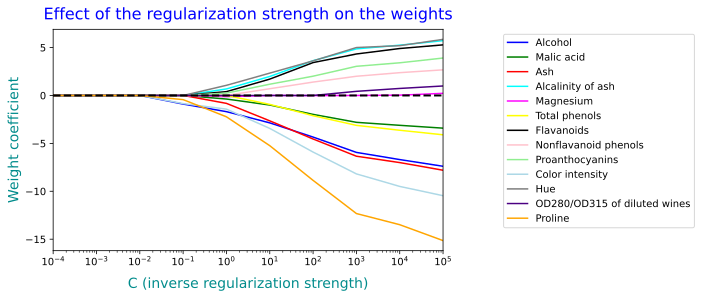

In [23]:
plt.figure(figsize=(7, 4))
plt.title("Effect of the regularization strength on the weights", fontsize=16, color='blue', pad=10)

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightgreen',
          'lightblue', 'gray', 'indigo', 'orange']
weights, params = [], []
for c in np.arange(-4., 6.):
    lr = OneVsRestClassifier(LogisticRegression(penalty='l1', C=10**c, solver='liblinear', random_state=1))
    lr.fit(X_train_std, y_train)
    # since 'lr' is an instance of OneVsRestClassifier, 'lr.estimators_' is the list of the estimators
    # used by 'lr'; 'lr.estimators_[1]' is the second logistic regression (it predicts class 1 vs the rest);
    # '.coef_' is its weight, given as a (1*n_features) NumPy array; so 'lr.estimators_[1].coef_[0]' contains
    # the learned weights for the second estimator
    weights.append(lr.estimators_[1].coef_[0])
    params.append(10**c)
weights = np.array(weights)
#* 'weights.shape[1]' is the number of columns in the 'weights' array, ie 13 (the number of features)
#* 'zip(range(weights.shape[1]), colors)' creates an iterator that generates pairs of elements, where
# each pair consists of an element from range(weights.shape[1]) and the corresponding element from
# colors. The iteration stops when the shorter of the two sequences (here both) is exhausted.
for column, color in zip(range(weights.shape[1]), colors):
    #* Each line represents how the weight coefficient for a specific feature changes with different
    # values of the regularization parameter C=10**c
    #* 'df_wine.columns[0]' corresponds to the labels of the wines
    plt.plot(params, weights[:, column], label=df_wine.columns[column + 1], color=color)

# 'plt.axhline(0,...)' corresponds to the horizontal line of ordinate 0
plt.axhline(0, color='black', linestyle='--', linewidth=2)
# use a logarithmic scale for the x-axis
plt.xscale('log')
plt.xlim([10**(-4), 10**5])
plt.xlabel("C (inverse regularization strength)", labelpad=10, fontsize=14, color='darkcyan')
plt.ylabel("Weight coefficient", fontsize=14, color='darkcyan')
#* the upper center of the legend box should be anchored at a point that is 1.4 times the width of
# the plot to the right and 1 times the height of the plot above the bottom left corner of the plot
#* 'ncol=1' specify that the legend box should have 1 column only
#* and 'fancybox=True' specify that it should have rounded corners
plt.legend(loc='upper center', bbox_to_anchor=(1.4, 1), ncol=1, fancybox=True)
plt.show()

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>4c. Sequential feature selection algorithms</font><a id="4c"></a></p>$\quad$
        An alternative way to reduce the complexity of a model and avoid overfitting is dimensionality reduction via feature selection, which is especially useful for unregularized models. There are two
main categories of dimensionality reduction techniques: feature selection and feature extraction. Via
$\,$<font color='darkpink'>feature selection</font>$\,$, we select a subset of the original features, whereas in $\,$<font color='darkpink'>feature extraction</font>$\,$, we derive information from the feature set to construct a new feature subspace.<br>
    In this section, we will take a look at a classic family of feature selection algorithms. In the next part we will learn about different feature extraction techniques to compress a dataset onto a lower-dimensional feature subspace.<br>$\quad$
        The motivation behind feature selection algorithms is to select a subset of features that are most relevant to the problem, in order to improve computational efficiency, or to reduce the generalization error of the model by removing irrelevant features or noise, which can be useful for algorithms that don’t support regularization.<br>$\quad$
        A classic sequential feature selection algorithm is $\,$<font color='darkpink'>sequential backward selection</font>$\,$ (SBS). The idea behind the SBS algorithm is quite simple : SBS sequentially removes features from the full feature subset until the new feature subspace contains the desired number of features. To determine which feature is to be removed at each stage, we need to define the criterion function, $J$, that we want to optimize. The criterion calculated by the criterion function can simply be the difference in the performance of the classifier before and after the removal of a particular feature : at each stage we eliminate the feature that causes the least performance loss after removal. We can outline the algorithm in four simple steps. But first, I need to introduce a family of permutations of $\{1,\cdots,n\}$, $\{\sigma_{\leq k}\,;\; k=0,\cdots,n\}$ : $\sigma_{\leq n}$ is the identity, and then, for any $k=n\!-\!1,\cdots,0\,$, $\;\sigma_{\leq k}$ has the same components from $k\!+\!2$ to $n$ (if any) as $\sigma_{\leq k+1}$, its $(k\!+\!1)$-th component as defined during the algorithm, and its first $k$-th components being determined from the remaining values in increasing order :<br><font color='purple'>
1. Initialize the algorithm with $k = n$, where $n$ is the dimensionality of the full feature space $X$, and define $X_{\leq n} \,=\, X$<br>
2. Determine the feature $X_l$ that minimizes the performance loss :<div style="margin-top: 10px"></div>
        $$X_l \;=\; \underset{j=1,\cdots,k}{\text{argmin}}\;\, J(X_{\leq k}\setminus\{X_{\sigma_{\leq k}(j)}\}) \qquad\quad (52)$$<div style="margin-top: 10px"></div>
3. Remove the feature $X_l$ from the feature set: $\;X_{\leq k-1} := X_{\leq k}\setminus\{X_l\}\;$, define $\;\sigma_{\leq k-1}(k) = l$, and decrement $\;k = k – 1$<br>
4. Terminate if $k$ equals the number of desired features; otherwise, go to step 2.

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    We now code this algorithm with the $\,$<font color='#cc33ff'>accuracy_score</font>$\,$ as the measure of performance by default :<br><br>

In [24]:
# 'clone' and 'combinations' are explained along the code
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
class SBS:
    # 'estimator' is the estimator, 'k_features' is the number of features that we want to keep,
    # 'scoring' measures the performance and 'test_size' is the percentage of our initial set of
    # instances (eg those in the training dataset) that we want to use for our test dataset here
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        # 'clone(estimator)' creates a deep copy of the provided estimator object so that any
        # internal state or modifications made during the feature selection process do not affect the
        # original model instance
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.scoring = scoring
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size,
                                                            random_state=self.random_state)
        # 'dim' is the number of features (columns) of X_train
        dim = X_train.shape[1]
        # creates a tuple of length dim, the number of features, going from 0 to dim-1
        self.indices_ = tuple(range(dim))
        # 'subsets' will store the subsets of features selected at each step of the algorithm; at the
        # start it contains a single element, the tuple 'self.indices' of all indices
        self.subsets_ = [self.indices_]
        # at the start, 'score' is the accuracy_score of the estimator on the whole training matrix
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        # we stop the algorithm when the number of columns left in the matrix is equal to
        # 'self.k_features'
        while dim > self.k_features:
            scores = []
            subsets = []
            # 'combinations(self.indices_, r = dim - 1)' generates all subsets of 'self.indices_' of
            # length 'r'
            for p in combinations(self.indices_, r = dim - 1):
                score = self._calc_score(X_train, y_train,X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            # now 'self.indices_' is the subset in 'subsets' which got the best accuracy_score
            self.indices_ = subsets[best]
            # so in the end, for any 'l', 'self.subsets[l]' will be the subset of (n-l) features with
            # the best accuracy_score ('n' being the initial number of features)
            self.subsets_.append(self.indices_)
            # and 'self.scores[l]' will be the best possible accuracy_score with (n-l) features
            self.scores_.append(scores[best])
            dim -= 1
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    # compute the score (by default the accuracy_score) of the estimator on a reduced training matrix
    # (which only has the columns whose indices are in 'indices')
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

<br><br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    Let’s see our SBS implementation in action using the KNN classifier from <font color='#cc33ff'>scikit-learn</font> (see part 3, "Appendix - k-nearest neighbors") :<br>

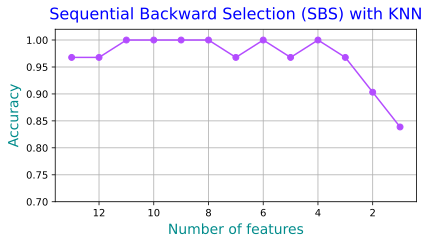

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)
# k_feat[i] is the number of features in the i-th subset (from 13 down to 1)
k_feat = [len(k) for k in sbs.subsets_]

plt.figure(figsize=(6, 3.5))
plt.title("Sequential Backward Selection (SBS) with KNN", fontsize=16, color='blue', pad=10)
plt.plot(k_feat, sbs.scores_, marker='o', color=cmap(0.7))
plt.xlabel("Number of features", labelpad=5, fontsize=14, color='darkcyan')
plt.ylim([0.7, 1.02])
plt.ylabel("Accuracy", labelpad=5, fontsize=14, color='darkcyan')
plt.grid()
# to go from 13 features to 1 instead of from 1 to 13
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    To satisfy our own curiosity, let’s see what the small feature subset (k=3) which yielded such a good performance looks like:

In [26]:
# 'sbs.subsets_[10]' is the set of remaining features when we have removed 10 of them; there are 13
# features at the start so it remains 3 of them, the 3 most important features
k3 = list(sbs.subsets_[10])
# 'df_wine.columns' is the set of columns' names of the 'df_wine' dataframe; 'df_wine.columns[1:]' is
# the set of names but starting at 1 (the 0-th is removed, it contains the labels of the wines, and
# was removed for the training dataset);
# 'df_wine.columns[1:][k3]' is thus the names of the 3 most important features
print(BB + "The 3 most important features are : " + MB, df_wine.columns[1:][k3].tolist(), "\n")

knn.fit(X_train_std, y_train)
print(BB + "Training accuracy when keeping all the features : " + MB, knn.score(X_train_std, y_train))
print(BB + "Test accuracy when keeping all the features : " + MB, knn.score(X_test_std, y_test), "\n")

knn.fit(X_train_std[:, k3], y_train)
print(BB + "Training accuracy when keeping only our 3 'best' features : " + MB, knn.score(X_train_std[:, k3], y_train))
print(BB + "Test accuracy when keeping only our 3 'best' features : " + MB, knn.score(X_test_std[:, k3], y_test))

The 3 most important features are :  ['Alcohol', 'Total phenols', 'Color intensity'] 

Training accuracy when keeping all the features :  0.9596774193548387
Test accuracy when keeping all the features :  0.9259259259259259 

Training accuracy when keeping only our 3 'best' features :  0.9354838709677419
Test accuracy when keeping only our 3 'best' features :  0.8888888888888888


<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>4d. Assessing feature importance with random forests</font><a id="4d"></a></p>$\quad$
        Another useful approach for selecting relevant features from a dataset is using a random forest (see part 3, "4d. Random forests"). Using a random forest, we can measure feature importance as the average decrease in impurity across all decision trees in the forest. Conveniently, the random forest implementation in <font color='#cc33ff'>scikit-learn</font> already collects the feature importance values for us so that we can access them via the $\,$<font color='#cc33ff'>feature_importances_</font>$\,$ attribute after fitting a <font color='#cc33ff'>RandomForestClassifier</font>. By executing the following code, we will now train a forest of 500 trees on the <font color='#cc33ff'>wine dataset</font> and rank the 13 features by their respective importance measures :

 1) Proline               0.179927
 2) Color intensity       0.153158
 3) Flavanoids            0.146123
 4) Alcohol               0.138224
 5) OD280/OD315 of diluted wines 0.114818
 6) Hue                   0.077525
 7) Total phenols         0.058236
 8) Malic acid            0.030856
 9) Alcalinity of ash     0.030000
10) Proanthocyanins       0.025713
11) Magnesium             0.025135
12) Nonflavanoid phenols  0.011548
13) Ash                   0.008738


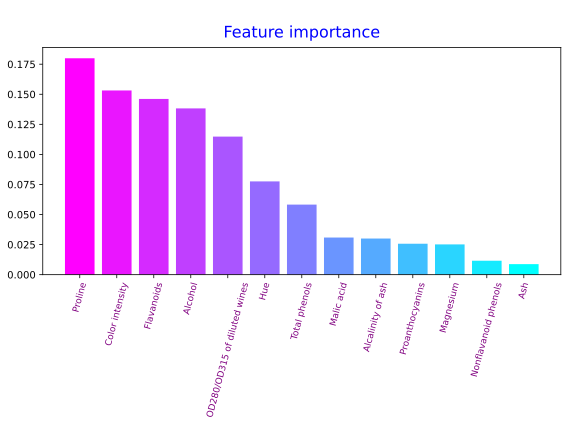

In [27]:
from sklearn.ensemble import RandomForestClassifier
# collects the columns' names starting at 1 (column 0 contains the class labels)
feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
# 'feature_importances_' is an attribute of the trained Random Forest model that contains an array of
# importance scores for each feature. The importance score reflects how much each feature contributes
# to the predictive performance of the model. Higher values indicate more important features.
importances = forest.feature_importances_
# 'np.argsort(importances)' returns an array of indices that would sort the importances array in
# ascending order; '[::-1]' reverses the order of the array, effectively sorting the importances
# array in descending order
indices = np.argsort(importances)[::-1]
# 'X_train.shape[1]' is the number of features (columns) of X_train
for f in range(X_train.shape[1]):
    #* '%2d' is a format specifier for an integer (d) with a width of 2. It is used to print the
    # feature index (f+1) with at least two characters, adding leading spaces if necessary
    #* '%-*s' is a format specifier for a string (s) with a variable width specified by the value
    # before the asterisk (*). The minus sign (-) indicates left alignment. It is used to print the
    # feature label (feat_labels[indices[f]]) with a width of 30 characters
    #* '%f' formats the number at the corresponding position, here 'importances[indices[f]]', into 
    # a floating point number with six decimal places
    print(BB + "%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]] + MB, importances[indices[f]]))

plt.figure(figsize=(8,6))
plt.title("\nFeature importance", fontsize=16, color='blue', pad=10)
# create a bar diagram where the x-axis represents the indices of the columns in X_train, the y-axis
# represents the feature importances (in descending order), and the bars are centered on the
# horizontal ticks
colors = plt.get_cmap("cool")(np.linspace(1, 0, X_train.shape[1]))
plt.bar(range(X_train.shape[1]), importances[indices], align='center', color=colors)
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=75, fontsize=9, color="purple")
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

<br><br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    We can conclude that the "proline" and "flavonoids" levels, the "color intensity", the "OD280/OD315" diffraction, and the "alcohol" concentration of wine are the most discriminative features in the dataset based on the average impurity decrease in the 500 decision trees. Interestingly, only two of the top-ranked features in the plot also appear among the "three most important features" identified by the SBS algorithm implemented in the previous section ("alcohol" concentration and "OD280/OD315 of diluted wines").<br>$\quad$
    However, as far as interpretability is concerned, the random forest technique comes with an important caveat. If two or more features are highly correlated, one feature may be ranked highly, while the information on the other(s) may not be fully captured. Therefore, we must consider this limitation if we care about feature interpretability. On the other hand, if we are primarily focused on the predictive performance of the model, this issue is less of a concern.<br><br>$\quad$
    <font color='#cc33ff'>scikit-learn</font> also implements a $\,$<font color='#cc33ff'>SelectFromModel</font>$\,$ object that selects features based on a user-specified threshold after model fitting, which is useful if we want to use the RandomForestClassifier as a feature selector :

In [28]:
from sklearn.feature_selection import SelectFromModel
# our 'forest' estimator has been fitted already, so 'prefit' is True
sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
# Apply the transformation to select features
X_selected = sfm.transform(X_train)
# Print the number of selected features
print(BB + "Number of features that meet the threshold criterion : " + MB, X_selected.shape[1])
# Display the selected features and their corresponding importances
for f in range(X_selected.shape[1]):
    # same as in the previous cell
    print(BB + "%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]] + MB, importances[indices[f]]))

Number of features that meet the threshold criterion :  5
 1) Proline               0.179927
 2) Color intensity       0.153158
 3) Flavanoids            0.146123
 4) Alcohol               0.138224
 5) OD280/OD315 of diluted wines 0.114818
